#### Data Preprocessing

Import the core libraries:

In [1]:
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_venn import venn2, venn3
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from adjustText import adjust_text

Now, set up file paths for TTC delay data and load the 2023, 2024 and 2025 files for subway, streetcar, and bus delays:

In [2]:
base_dir = 'Datasets'

# Subway data
subway_dir = os.path.join(base_dir, 'ttc-subway-delay-data')
subway_2023 = pd.read_excel(os.path.join(subway_dir, 'ttc-subway-delay-data-2023.xlsx'))
subway_2024 = pd.read_excel(os.path.join(subway_dir, 'ttc-subway-delay-data-2024.xlsx'))
subway_2025 = pd.read_csv(os.path.join(subway_dir, 'TTC Subway Delay Data since 2025.csv'))

# Streetcar data
streetcar_dir = os.path.join(base_dir, 'ttc-streetcar-delay-data')
streetcar_2023 = pd.read_excel(os.path.join(streetcar_dir, 'ttc-streetcar-delay-data-2023.xlsx'))
streetcar_2024 = pd.read_excel(os.path.join(streetcar_dir, 'ttc-streetcar-delay-data-2024.xlsx'))
streetcar_2025 = pd.read_csv(os.path.join(streetcar_dir, 'TTC Streetcar Delay Data since 2025.csv'))

# Bus data
bus_dir = os.path.join(base_dir, 'ttc-bus-delay-data')
bus_2023 = pd.read_excel(os.path.join(bus_dir, 'ttc-bus-delay-data-2023.xlsx'))
bus_2024 = pd.read_excel(os.path.join(bus_dir, 'ttc-bus-delay-data-2024.xlsx'))
bus_2025 = pd.read_csv(os.path.join(bus_dir, 'TTC Bus Delay Data since 2025.csv'))

# rename 'Station' → 'Location' for 2025 files
bus_2025 = bus_2025.rename(columns={'Station': 'Location'})
streetcar_2025 = streetcar_2025.rename(columns={'Station': 'Location'})

# combine yearly dataframes for each transit mode
subway_all = pd.concat([subway_2023, subway_2024, subway_2025], ignore_index=True)
streetcar_all = pd.concat([streetcar_2023, streetcar_2024, streetcar_2025], ignore_index=True)
bus_all = pd.concat([bus_2023, bus_2024, bus_2025], ignore_index=True)

Check for missing values in essential columns across all transit modes, as well as for each dataset (by year) and show both raw counts and percentages:

In [3]:
expected_columns = {
    'bus':     ['Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap'],
    'streetcar': ['Date', 'Line', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap'],
    'subway':  ['Date', 'Time', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap']
}

# map each df to its mode + year
datasets = {
    'Bus 2023': (bus_2023, expected_columns['bus']),
    'Bus 2024': (bus_2024, expected_columns['bus']),
    'Bus 2025': (bus_2025, expected_columns['bus']),
    'Streetcar 2023': (streetcar_2023, expected_columns['streetcar']),
    'Streetcar 2024': (streetcar_2024, expected_columns['streetcar']),
    'Streetcar 2025': (streetcar_2025, expected_columns['streetcar']),
    'Subway 2023': (subway_2023, expected_columns['subway']),
    'Subway 2024': (subway_2024, expected_columns['subway']),
    'Subway 2025': (subway_2025, expected_columns['subway'])
}


summary = []

for name, (df, cols) in datasets.items():
    for col in cols:
        if col in df.columns:
            count = df[col].isna().sum()
            percent = round((count / len(df)) * 100, 2)
            if count > 0:
                summary.append([name, col, count, percent])


missing_summary_df = pd.DataFrame(summary, columns=['Dataset', 'Column', 'Missing Count', 'Missing %'])

# summary
pd.set_option('display.max_rows', None)
display(missing_summary_df)

Dataset     Column  Missing Count  Missing %
0         Bus 2023      Route            570       1.01
1         Bus 2024      Route            622       1.04
2         Bus 2025      Route             46       1.19
3         Bus 2025  Min Delay            378       9.75
4         Bus 2025    Min Gap            380       9.81
5   Streetcar 2023       Line            128       0.89
6   Streetcar 2024       Line            156       1.10
7   Streetcar 2024   Location              1       0.01
8   Streetcar 2025       Line             11       1.07
9   Streetcar 2025  Min Delay            199      19.41
10  Streetcar 2025    Min Gap            199      19.41
11     Subway 2025  Min Delay           1296      61.60
12     Subway 2025    Min Gap           1341      63.74

Let’s inspect and then clean subway 2025 Min Delay and Min Gap:

In [4]:
print("Unique 'Min Delay' values (raw):", subway_2025['Min Delay'].unique())
print("Unique 'Min Gap' values (raw):", subway_2025['Min Gap'].unique())

Unique 'Min Delay' values (raw): [  5.  nan   9.   4.   3.  12.   6.   7.  19.  16.  23.   8.  26.  18.
  14.  11.  10.  90.  24.  15.  22.  17.  20.  13.  25.  21.  75.  64.
  27.  40.  29.  54.  34.  85.  36. 360.  28.  89.  30.  32.]
Unique 'Min Gap' values (raw): [  9.  nan  10.   8.   7.  16.  13.  12.   6.  11.  23.  15.   5.  26.
  30.  21.  17.  19.  20.  14.  96.  28.  18.  22.  24.  25.  77.  70.
  44.  34.  57.  43.  39.  88. 364.  32.  41.  92.  35.  33.  38.  36.]


A significant number of missing values are in the Min Delay and Min Gap columns, particularly in the 2025 subway and streetcar datasets. These missing entries appeared in the original files as empty cells and were parsed as NaN (Not a Number) by pandas. Upon manual inspection, these blanks were displayed as "None", which further indicated the absence of an actual delay record rather than data corruption or entry error.

Given the context of delay reporting, I interpreted these missing values as representing instances where no delay or gap occurred.

Therefore, it is both reasonable and practical to impute missing values in Min Delay and Min Gap as 0, indicating a lack of disruption:

In [5]:
# drop missing Route/Line/Location where applicable, and fill delays with 0
def clean_transit_df(df, required_cols):
    df_cleaned = df.dropna(subset=[col for col in required_cols if col in df.columns]).copy()
    if 'Min Delay' in df_cleaned.columns:
        df_cleaned['Min Delay'] = df_cleaned['Min Delay'].fillna(0)
    if 'Min Gap' in df_cleaned.columns:
        df_cleaned['Min Gap'] = df_cleaned['Min Gap'].fillna(0)
    return df_cleaned

# define required non-null columns
bus_required = ['Route']
streetcar_required = ['Line', 'Location']
subway_required = ['Line']

# cleaning
bus_2023_clean = clean_transit_df(bus_2023, bus_required)
bus_2024_clean = clean_transit_df(bus_2024, bus_required)
bus_2025_clean = clean_transit_df(bus_2025, bus_required)

streetcar_2023_clean = clean_transit_df(streetcar_2023, streetcar_required)
streetcar_2024_clean = clean_transit_df(streetcar_2024, streetcar_required)
streetcar_2025_clean = clean_transit_df(streetcar_2025, streetcar_required)

subway_2023_clean = clean_transit_df(subway_2023, subway_required)
subway_2024_clean = clean_transit_df(subway_2024, subway_required)
subway_2025_clean = clean_transit_df(subway_2025, subway_required)

bus_all_clean = pd.concat([bus_2023_clean, bus_2024_clean, bus_2025_clean], ignore_index=True)
streetcar_all_clean = pd.concat([streetcar_2023_clean, streetcar_2024_clean, streetcar_2025_clean], ignore_index=True)
subway_all_clean = pd.concat([subway_2023_clean, subway_2024_clean, subway_2025_clean], ignore_index=True)

Now that the data has been cleaned, let's perform a series of sanity checks to verify that key fields are populated, numeric fields are reasonable, and each dataset looks consistent across years and modes:

In [6]:
cleaned_dfs = {
    'Bus 2023': bus_2023_clean,
    'Bus 2024': bus_2024_clean,
    'Bus 2025': bus_2025_clean,
    'Streetcar 2023': streetcar_2023_clean,
    'Streetcar 2024': streetcar_2024_clean,
    'Streetcar 2025': streetcar_2025_clean,
    'Subway 2023': subway_2023_clean,
    'Subway 2024': subway_2024_clean,
    'Subway 2025': subway_2025_clean
}


for name, df in cleaned_dfs.items():
    print(f"\n=== {name} ===")
    print("-" * 40)
    print(f"Rows: {len(df)}")
    
    # check for any remaining nulls
    nulls = df.isna().sum()
    nulls = nulls[nulls > 0]
    if not nulls.empty:
        print("Remaining missing values:")
        print(nulls)
    else:
        print("✅ No missing values in any column.")
    
    # Min/Max for numeric delay columns
    for col in ['Min Delay', 'Min Gap']:
        if col in df.columns:
            print(f"{col} → Min: {df[col].min()}, Max: {df[col].max()}, Mean: {round(df[col].mean(), 2)}")
    
    # check date range
    if 'Date' in df.columns:
        try:
            parsed_dates = pd.to_datetime(df['Date'], errors='coerce')
            print(f"Date range: {parsed_dates.min().date()} → {parsed_dates.max().date()}")
        except Exception as e:
            print("Date parsing error:", e)


=== Bus 2023 ===
----------------------------------------
Rows: 55637
Remaining missing values:
Direction    9074
dtype: int64
Min Delay → Min: 0, Max: 998, Mean: 20.41
Min Gap → Min: 0, Max: 992, Mean: 33.16
Date range: 2023-01-01 → 2023-12-31

=== Bus 2024 ===
----------------------------------------
Rows: 59021
Remaining missing values:
Direction    9052
dtype: int64
Min Delay → Min: 0, Max: 975, Mean: 21.4
Min Gap → Min: 0, Max: 997, Mean: 33.94
Date range: 2024-01-01 → 2024-12-31

=== Bus 2025 ===
----------------------------------------
Rows: 3829
Remaining missing values:
Bound      600
Vehicle    115
dtype: int64
Min Delay → Min: 0.0, Max: 841.0, Mean: 18.96
Min Gap → Min: 0.0, Max: 856.0, Mean: 31.48
Date range: 2025-01-01 → 2025-01-31

=== Streetcar 2023 ===
----------------------------------------
Rows: 14285
Remaining missing values:
Bound    2142
dtype: int64
Min Delay → Min: 0, Max: 960, Mean: 15.66
Min Gap → Min: 0, Max: 968, Mean: 23.41
Date range: 2023-01-01 → 2023-12

Now, let’s load our mapping file for subway delay codes and join the corresponding human-readable description for each Code:

In [7]:
code_map_path = os.path.join(subway_dir, 'subway_delay_codes_adjusted.csv')
subway_code_map_df = pd.read_csv(code_map_path)

subway_code_map_df.columns = subway_code_map_df.columns.str.strip()
subway_code_map_df = subway_code_map_df.rename(columns={'Code': 'Code', 'CODE DESCRIPTION': 'Code Description'})

# create mapping dictionary
subway_code_map = dict(zip(subway_code_map_df['Code'], subway_code_map_df['Code Description']))

# add 'Code Description' column to each subway dataset
for df in [subway_2023_clean, subway_2024_clean, subway_2025_clean, subway_all_clean]:
    df['Code Description'] = df['Code'].map(subway_code_map)


In [8]:
# check for missing code descriptions and how many unique codes are missing
for name, df in zip(['2023', '2024', '2025', 'All Years'], 
                    [subway_2023_clean, subway_2024_clean, subway_2025_clean, subway_all_clean]):
    missing_desc = df['Code Description'].isna().sum()
    total = len(df)
    unique_missing_codes = df.loc[df['Code Description'].isna(), 'Code'].nunique()
    
    print(f"Subway {name}: {missing_desc} missing descriptions out of {total} rows")
    print(f" → Unique missing codes: {unique_missing_codes}")
    print("-" * 50)

subway_all_clean[['Code', 'Code Description']].drop_duplicates().head(10)


Subway 2023: 531 missing descriptions out of 22901 rows
 → Unique missing codes: 8
--------------------------------------------------
Subway 2024: 993 missing descriptions out of 26423 rows
 → Unique missing codes: 8
--------------------------------------------------
Subway 2025: 92 missing descriptions out of 2099 rows
 → Unique missing codes: 5
--------------------------------------------------
Subway All Years: 1616 missing descriptions out of 51423 rows
 → Unique missing codes: 9
--------------------------------------------------


Code                                   Code Description
0   MUPAA  Passenger Assistance Alarm Activated - No Trou...
1    MUIS  Injured or ill Customer (In Station) - Transpo...
2     SUO                                    Passenger Other
5   MUNCA                                                NaN
7   TUNOA                 No Operator Immediately Available 
8   MUNOA  No Operator Immediately Available - Not E.S.A....
9    EUSC                          Speed Control Equipment  
14    SUG                              Graffiti / Scratchiti
18  PUSRA                         Subway Radio System Fault 
19  TUNIP                           Operator Not In Position

After double-checking the source, turns out the TTC didn’t include every code in their original description file, therefore we'll leave some of the decriptions as NaN for now.

Now, let's check how many unique entries in the Line column for streetcars and subway:

In [9]:
def count_entries_per_line(df, column_name='Line', label=''):
    counts = (
        df[column_name]
        .dropna()
        .astype(str)
        .str.strip()
        .value_counts()
        .sort_values(ascending=False)
    )
    
    print(f"\nNumber of entries for each unique line ({label}):")
    print(counts)
    return counts

subway_line_counts = count_entries_per_line(subway_all_clean, column_name='Line', label='Subway')
streetcar_line_counts = count_entries_per_line(streetcar_all_clean, column_name='Line', label='Streetcar')



Number of entries for each unique line (Subway):
Line
YU                        26862
BD                        21355
SHP                        1685
SRT                         734
YU/BD                       697
YU/ BD                       20
YU / BD                      17
YUS/BD                       15
YUS                           8
YU & BD                       7
BD/YU                         7
BD LINE 2                     2
BLOOR DANFORTH & YONGE        1
TRACK LEVEL ACTIVITY          1
999                           1
BLOOR DANFORTH                1
SHEP                          1
LINE 1                        1
109 RANEE                     1
77 SWANSEA                    1
ONGE-UNIVERSITY AND BL        1
YU/BD/SHP                     1
BD / YU                       1
BD/ YUS                       1
BD/ YU                        1
20 CLIFFSIDE                  1
Name: count, dtype: int64

Number of entries for each unique line (Streetcar):
Line
501                      6538

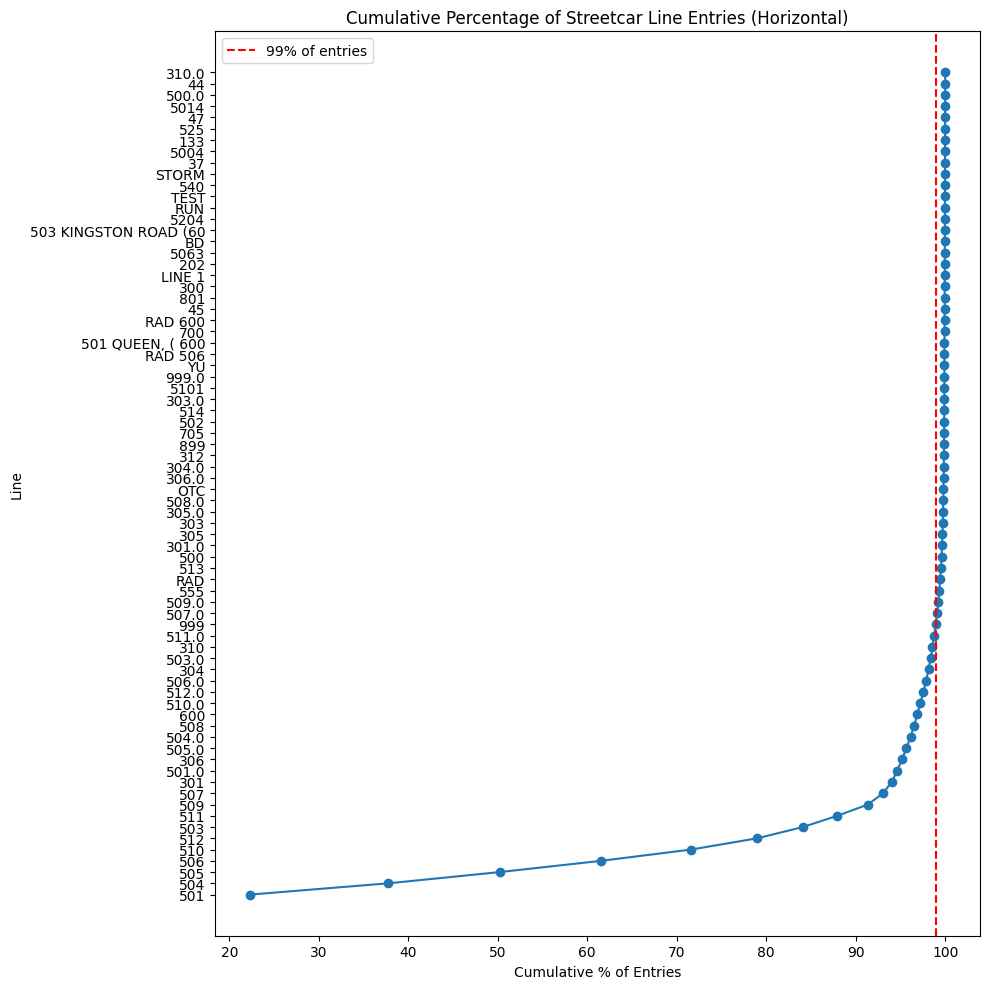

In [10]:
# convert the value_counts result to a DataFrame
streetcar_lines_df = streetcar_line_counts.reset_index()
streetcar_lines_df.columns = ['Line', 'Count']
streetcar_lines_df['Cumulative Count'] = streetcar_lines_df['Count'].cumsum()
streetcar_lines_df['Cumulative %'] = 100 * streetcar_lines_df['Cumulative Count'] / streetcar_lines_df['Count'].sum()

# plot cumulative distribution with horizontal orientation
plt.figure(figsize=(10, 10))
plt.plot(streetcar_lines_df['Cumulative %'], streetcar_lines_df['Line'], marker='o')
plt.yticks(rotation=0)
plt.axvline(99, color='red', linestyle='--', label='99% of entries')
plt.title("Cumulative Percentage of Streetcar Line Entries (Horizontal)")
plt.xlabel("Cumulative % of Entries")
plt.ylabel("Line")
plt.legend()
plt.tight_layout()
plt.show()


To remove inconsistencies in streetcar line data, let's convert float-style lines to string integers and drop noisy or malformed lines with fewer than 50 entries. For Subway data, there is a significant disparity between top 5 line types and everything else (surprising, considering there were a maximum of 4 operationl lines in Toronto's history, but some accidents happen at the intersections and those have their own label), so let's keep only those:

In [11]:
# standardize Line entries (turn floats like 501.0 into '501')
streetcar_all_clean['Line'] = (
    streetcar_all_clean['Line']
    .astype(str)
    .str.extract(r'(\d+)')  # extract numeric part only
    .fillna(streetcar_all_clean['Line'])  # fallback to original if no number found
)

# re-count and filter out rare lines
line_counts_cleaned = streetcar_all_clean['Line'].value_counts()
valid_lines = line_counts_cleaned[line_counts_cleaned >= 50].index

# filter dataset to only keep valid lines
streetcar_all_clean = streetcar_all_clean[streetcar_all_clean['Line'].isin(valid_lines)].copy()

# print what was removed
removed_lines = line_counts_cleaned[line_counts_cleaned < 50]
print("Removed lines (less than 50 entries):")
print(removed_lines)

# get the 5 most common valid subway lines
top_5_lines = subway_all_clean['Line'].value_counts().head(5).index.tolist()

# filter the dataset to only those lines
subway_all_clean = subway_all_clean[subway_all_clean['Line'].isin(top_5_lines)].copy()

# confirm result
print("Subway lines after filtering:")
print(subway_all_clean['Line'].value_counts())


Removed lines (less than 50 entries):
Line
509     39
555     34
513     26
305     23
500     19
303     14
312      5
899      3
705      3
502      2
5101     2
514      2
45       1
133      1
47       1
5004     1
5014     1
5063     1
700      1
1        1
300      1
801      1
525      1
37       1
202      1
5204     1
540      1
44       1
Name: count, dtype: int64
Subway lines after filtering:
Line
YU       26862
BD       21355
SHP       1685
SRT        734
YU/BD      697
Name: count, dtype: int64


Let's look at the Bus Routes and Stations columns as well:

Unique Bus Routes: 313

Top 10 most common routes:
Route
32     3788
36     3326
52     3205
29     2755
35     2710
7      2312
63     2230
102    2008
54     2005
95     1899
Name: count, dtype: int64

Bottom 10 least common routes:
Route
52 LAWRENCE WEST - 600    1
600 - ROUTE 301           1
1176                      1
600 (75                   1
600 - ROUTE LINE 1        1
LINE1                     1
9525                      1
362                       1
460                       1
9060                      1
Name: count, dtype: int64
Unique Bus Locations: 17463
Unique Streetcar Locations: 3760
Unique Subway Stations: 651


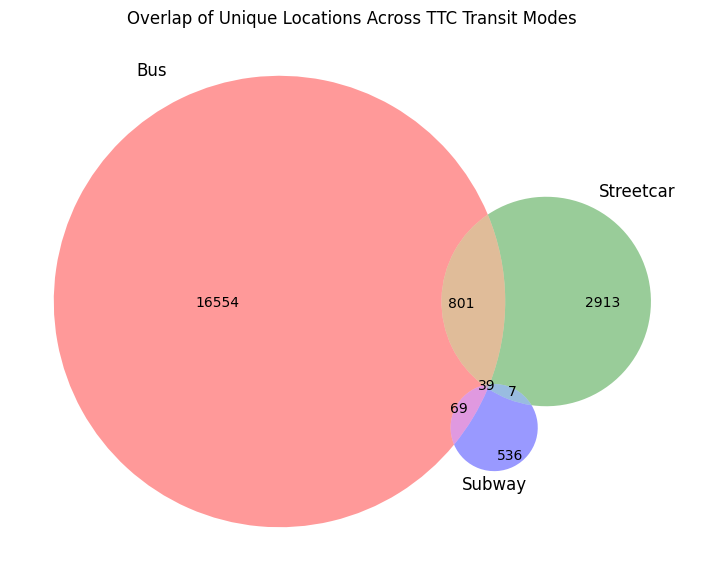

In [12]:
# clean 'Route' in bus data
bus_all_clean['Route'] = bus_all_clean['Route'].astype(str).str.strip().str.upper()

# clean 'Station' in subway data
subway_all_clean['Station'] = subway_all_clean['Station'].astype(str).str.strip().str.upper()

# standardize location names to uppercase for all datasets
for df in [bus_2023_clean, bus_2024_clean, bus_2025_clean, bus_all_clean]:
    df['Location'] = df['Location'].astype(str).str.strip().str.upper()
    df['Route'] = df['Route'].astype(str).str.strip().str.upper()

for df in [streetcar_2023_clean, streetcar_2024_clean, streetcar_2025_clean, streetcar_all_clean]:
    df['Location'] = df['Location'].astype(str).str.strip().str.upper()
    df['Line'] = df['Line'].astype(str).str.strip().str.upper()

for df in [subway_2023_clean, subway_2024_clean, subway_2025_clean, subway_all_clean]:
    df['Station'] = df['Station'].astype(str).str.strip().str.upper()
    df['Line'] = df['Line'].astype(str).str.strip().str.upper()


route_counts = bus_all_clean['Route'].value_counts()
print(f"Unique Bus Routes: {len(route_counts)}")
print("\nTop 10 most common routes:")
print(route_counts.head(10))
print("\nBottom 10 least common routes:")
print(route_counts.tail(10))

station_counts = subway_all_clean['Station'].value_counts()

# extract unique locations
bus_locations = set(bus_all_clean['Location'].dropna().unique())
streetcar_locations = set(streetcar_all_clean['Location'].dropna().unique())
subway_locations = set(subway_all_clean['Station'].dropna().unique())


print(f"Unique Bus Locations: {len(bus_locations)}")
print(f"Unique Streetcar Locations: {len(streetcar_locations)}")
print(f"Unique Subway Stations: {len(subway_locations)}")

# plot Venn diagram
plt.figure(figsize=(10, 7))
venn3(
    [bus_locations, streetcar_locations, subway_locations],
    set_labels=('Bus', 'Streetcar', 'Subway')
)
plt.title("Overlap of Unique Locations Across TTC Transit Modes")
plt.show()


Considering even before Line 3 closure, there were less than a 100 subway stations in Toronto, let's look at how many stations we actually need to capture 99% of the accidents entries' distribution and keep only those (and let's do the same for streetcar and bus data):

In [13]:
# Subway station distribution
subway_station_counts = subway_all_clean['Station'].value_counts().sort_values(ascending=False)
subway_stations_df = subway_station_counts.reset_index()
subway_stations_df.columns = ['Station', 'Count']
subway_stations_df['Cumulative Count'] = subway_stations_df['Count'].cumsum()
subway_stations_df['Cumulative %'] = 100 * subway_stations_df['Cumulative Count'] / subway_stations_df['Count'].sum()

# Bus location distribution
bus_location_counts = bus_all_clean['Location'].value_counts().sort_values(ascending=False)
bus_locations_df = bus_location_counts.reset_index()
bus_locations_df.columns = ['Location', 'Count']
bus_locations_df['Cumulative Count'] = bus_locations_df['Count'].cumsum()
bus_locations_df['Cumulative %'] = 100 * bus_locations_df['Cumulative Count'] / bus_locations_df['Count'].sum()

# Streetcar location distribution
streetcar_location_counts = streetcar_all_clean['Location'].value_counts().sort_values(ascending=False)
streetcar_locations_df = streetcar_location_counts.reset_index()
streetcar_locations_df.columns = ['Location', 'Count']
streetcar_locations_df['Cumulative Count'] = streetcar_locations_df['Count'].cumsum()
streetcar_locations_df['Cumulative %'] = 100 * streetcar_locations_df['Cumulative Count'] / streetcar_locations_df['Count'].sum()

print(f"Subway: {len(subway_stations_df[subway_stations_df['Cumulative %'] <= 99])} stations")
print(f"Bus: {len(bus_locations_df[bus_locations_df['Cumulative %'] <= 99])} locations")
print(f"Streetcar: {len(streetcar_locations_df[streetcar_locations_df['Cumulative %'] <= 99])} locations")

# Get the stations to keep for each transit mode (those responsible for 99% of entries)
subway_stations_to_keep = subway_stations_df[subway_stations_df['Cumulative %'] <= 99]['Station'].tolist()
bus_locations_to_keep = bus_locations_df[bus_locations_df['Cumulative %'] <= 99]['Location'].tolist()
streetcar_locations_to_keep = streetcar_locations_df[streetcar_locations_df['Cumulative %'] <= 99]['Location'].tolist()

Subway: 194 stations
Bus: 16278 locations
Streetcar: 3468 locations


In [14]:
# filter subway, bus and streetcar dataframes to keep only the stations responsible for 99% of entries
subway_2023_clean = subway_2023_clean[subway_2023_clean['Station'].isin(subway_stations_to_keep)].copy()
subway_2024_clean = subway_2024_clean[subway_2024_clean['Station'].isin(subway_stations_to_keep)].copy()
subway_2025_clean = subway_2025_clean[subway_2025_clean['Station'].isin(subway_stations_to_keep)].copy()
subway_all_clean = subway_all_clean[subway_all_clean['Station'].isin(subway_stations_to_keep)].copy()
bus_2023_clean = bus_2023_clean[bus_2023_clean['Location'].isin(bus_locations_to_keep)].copy()
bus_2024_clean = bus_2024_clean[bus_2024_clean['Location'].isin(bus_locations_to_keep)].copy()
bus_2025_clean = bus_2025_clean[bus_2025_clean['Location'].isin(bus_locations_to_keep)].copy()
bus_all_clean = bus_all_clean[bus_all_clean['Location'].isin(bus_locations_to_keep)].copy()
streetcar_2023_clean = streetcar_2023_clean[streetcar_2023_clean['Location'].isin(streetcar_locations_to_keep)].copy()
streetcar_2024_clean = streetcar_2024_clean[streetcar_2024_clean['Location'].isin(streetcar_locations_to_keep)].copy()
streetcar_2025_clean = streetcar_2025_clean[streetcar_2025_clean['Location'].isin(streetcar_locations_to_keep)].copy()
streetcar_all_clean = streetcar_all_clean[streetcar_all_clean['Location'].isin(streetcar_locations_to_keep)].copy()

print(f"Subway data: {len(subway_all_clean)} rows after filtering")
print(f"Bus data: {len(bus_all_clean)} rows after filtering")
print(f"Streetcar data: {len(streetcar_all_clean)} rows after filtering")

Subway data: 50817 rows after filtering
Bus data: 117302 rows after filtering
Streetcar data: 28868 rows after filtering


Quick check:

Unique Bus Locations: 16278
Unique Streetcar Locations: 3468
Unique Subway Stations: 194


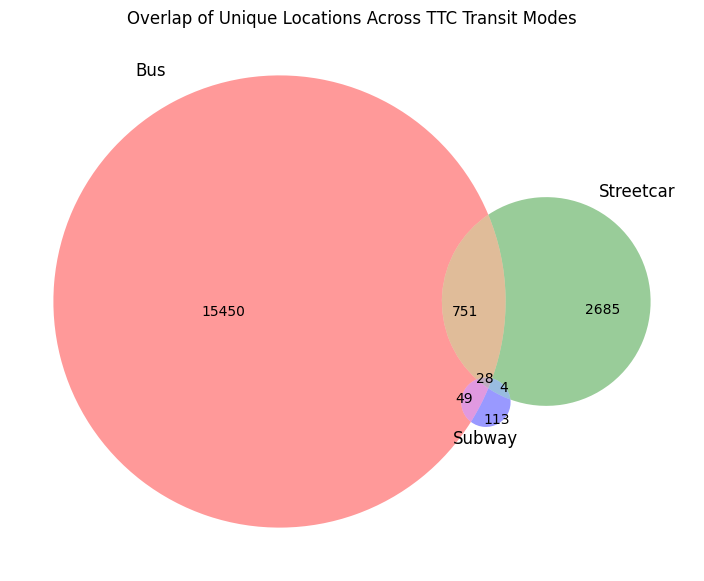

In [15]:
bus_locations = set(bus_all_clean['Location'].dropna().unique())
streetcar_locations = set(streetcar_all_clean['Location'].dropna().unique())
subway_locations = set(subway_all_clean['Station'].dropna().unique())

print(f"Unique Bus Locations: {len(bus_locations)}")
print(f"Unique Streetcar Locations: {len(streetcar_locations)}")
print(f"Unique Subway Stations: {len(subway_locations)}")

plt.figure(figsize=(10, 7))
venn3(
    [bus_locations, streetcar_locations, subway_locations],
    set_labels=('Bus', 'Streetcar', 'Subway')
)
plt.title("Overlap of Unique Locations Across TTC Transit Modes")
plt.show()

Surprisingly, the number of unique subway stations went from 651 down to 194.

Given the scope of the project and time constraints, no further cleaning was performed. These remaining inconsistencies are acknowledged, and further refinement could improve location-based analysis in the future.

#### Exploratory Data Analysis

First, let's explore how many distinct types of incidents have been recorded across buses, streetcars, and subways:

In [17]:
bus_incidents = bus_all_clean['Incident'].dropna().unique()
streetcar_incidents = streetcar_all_clean['Incident'].dropna().unique()
subway_codes = subway_all_clean['Code'].dropna().unique()

print("Unique Incident Types:")
print("- Bus:", len(bus_incidents))
print("- Streetcar:", len(streetcar_incidents))
print("- Subway:", len(subway_codes))

Unique Incident Types:
- Bus: 13
- Streetcar: 14
- Subway: 180


Let's see if Bus and Streetcar incidents overlap:

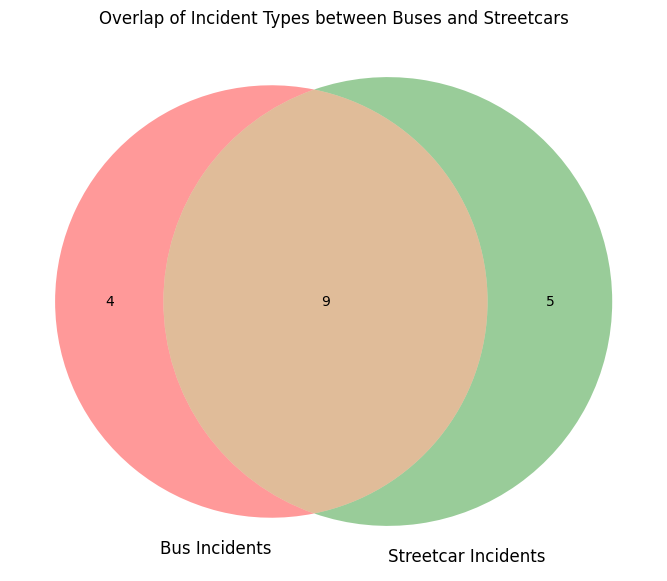

In [18]:
bus_set = set(bus_incidents)
streetcar_set = set(streetcar_incidents)

# Venn Diagram
plt.figure(figsize=(10, 7))
venn2([bus_set, streetcar_set], set_labels=('Bus Incidents', 'Streetcar Incidents'))
plt.title("Overlap of Incident Types between Buses and Streetcars")
plt.show()

Let's now visualize how frequently each type of incident occurred for buses and streetcars. We'll plot horizontal bar charts for overall frequency and then separate charts by year to detect trends or anomalies, using a shared color palette for incident types (since there is a significant overlap between unique types) to ensure consistent visual meaning across both transit modes:

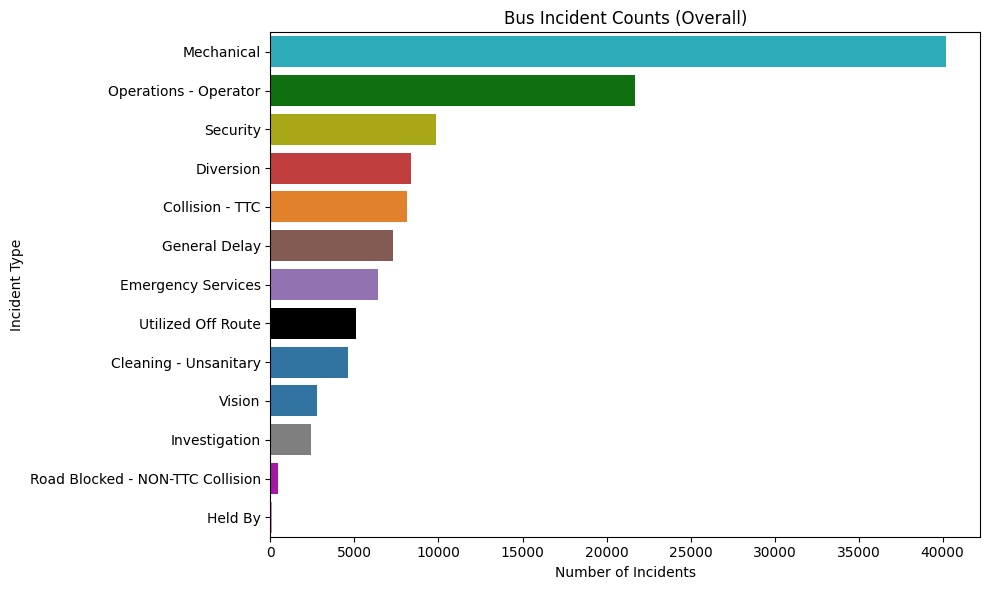

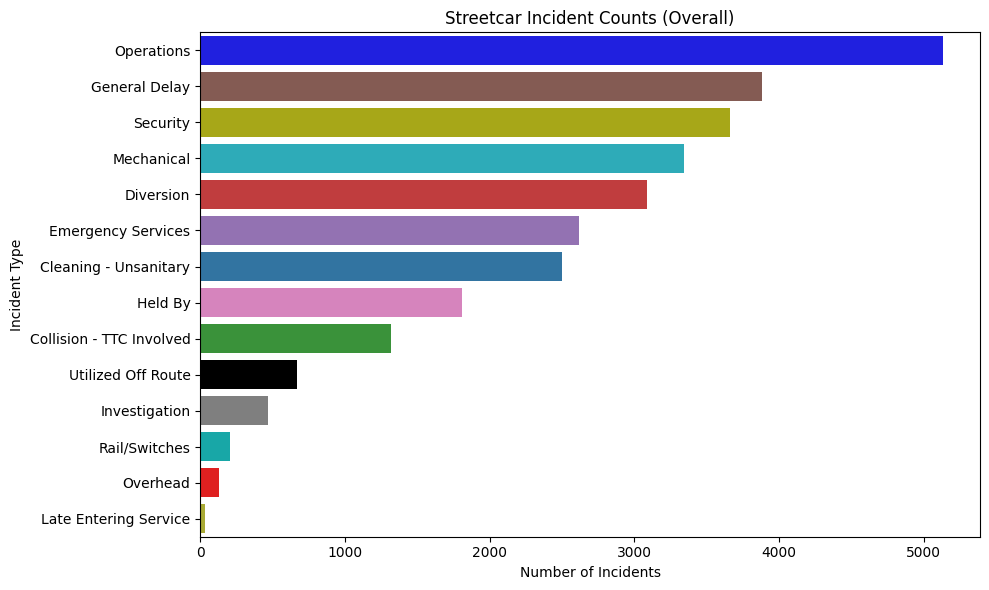

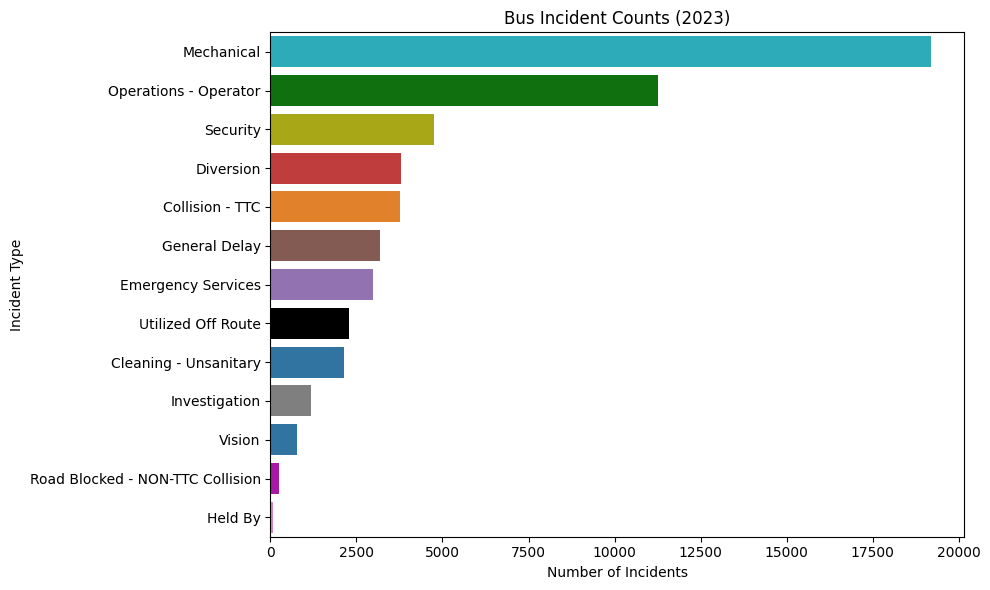

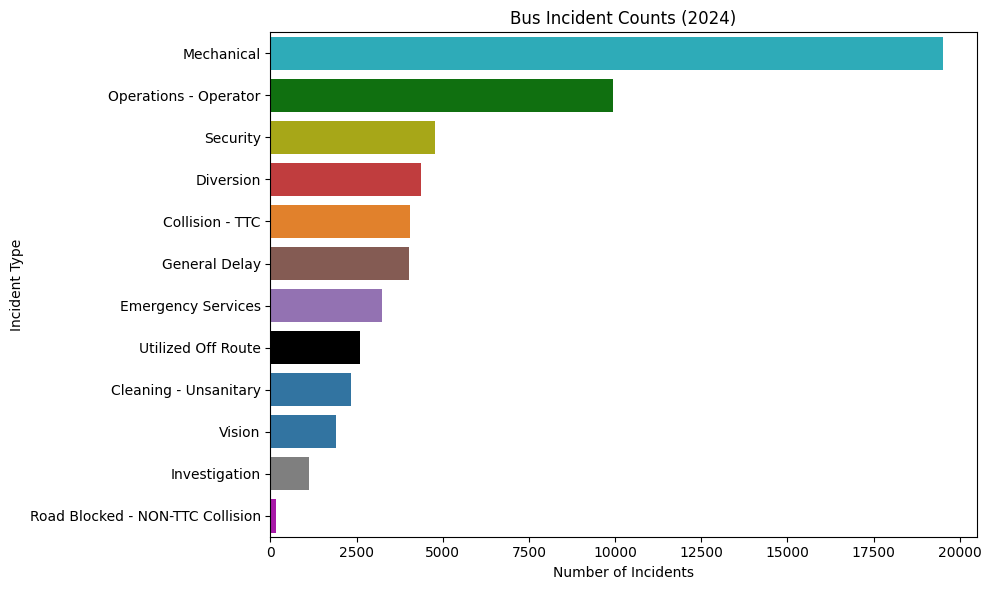

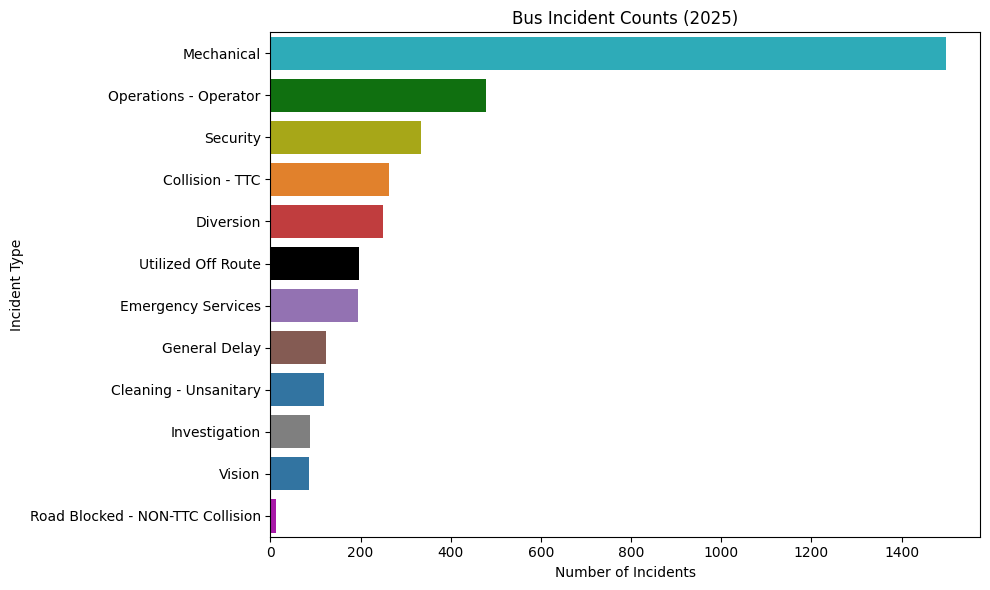

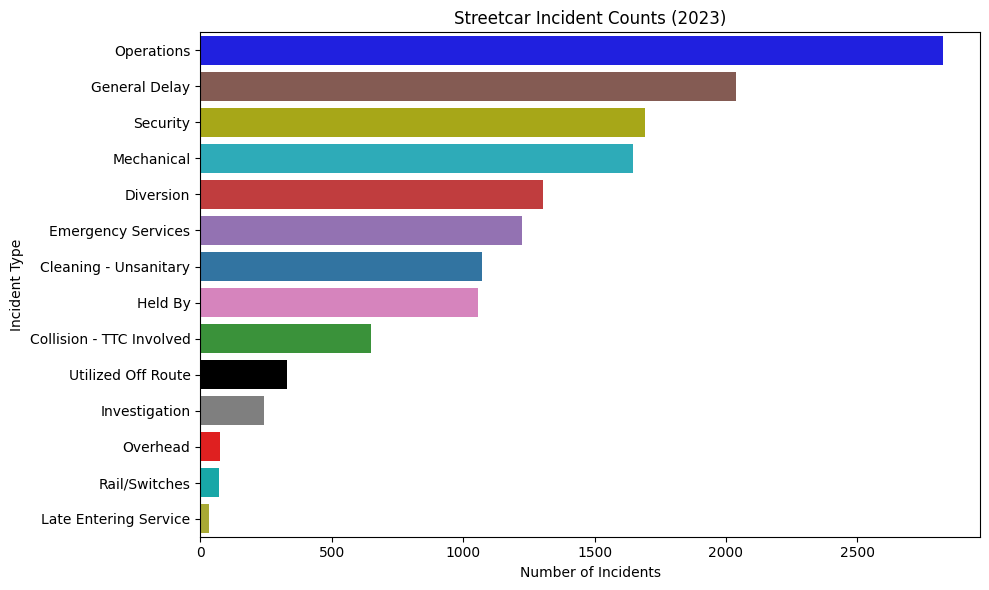

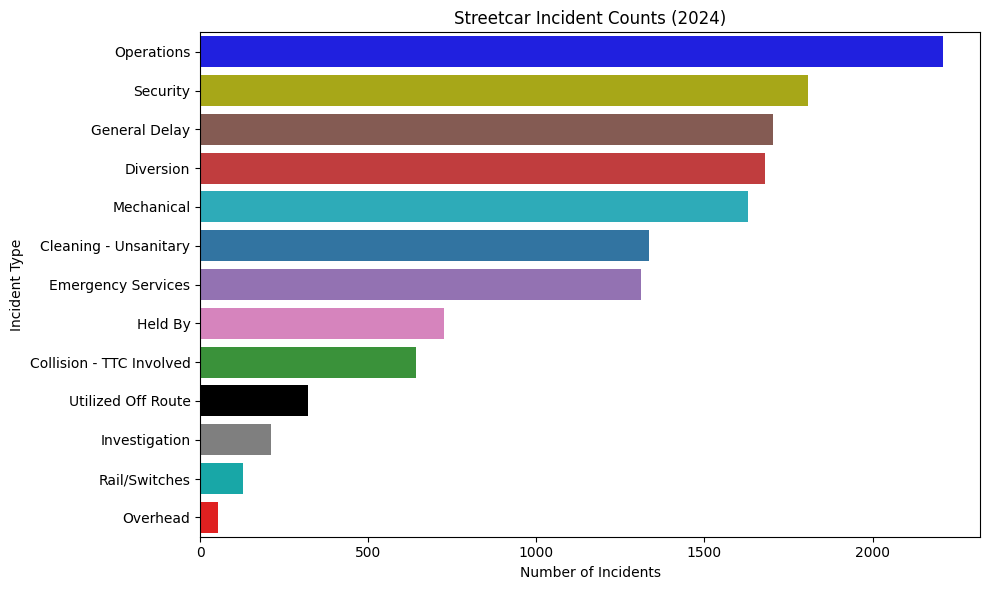

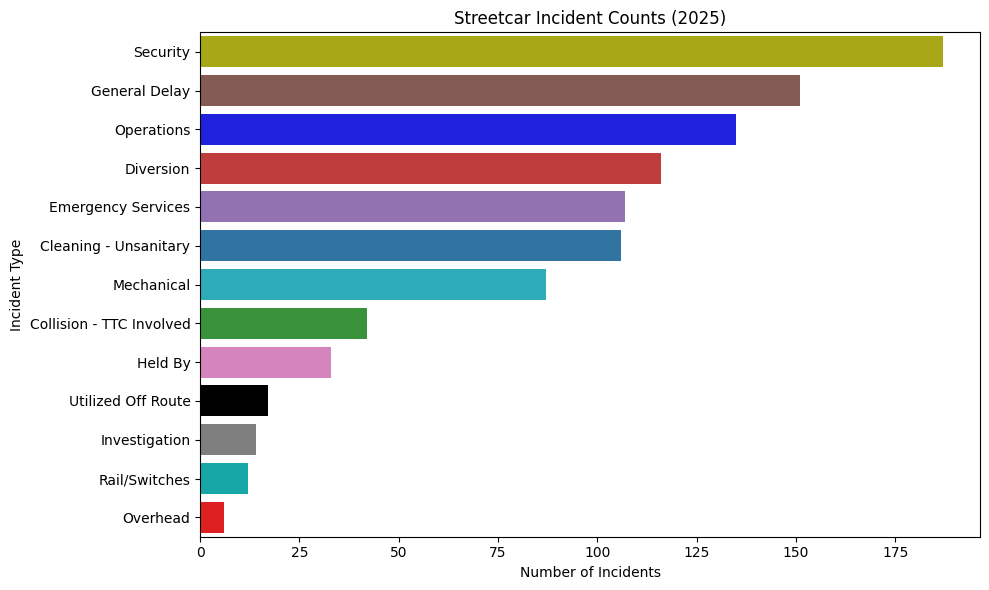

In [23]:
# create a consistent colour map across both bus and streetcar incidents
shared_incidents = set(bus_all_clean['Incident'].dropna()) | set(streetcar_all_clean['Incident'].dropna())

# assign colours
base_colors = [c for c in mcolors.TABLEAU_COLORS.values()] + \
              [c for name, c in mcolors.BASE_COLORS.items() if name != 'w']
extended_palette = base_colors * ((len(shared_incidents) // len(base_colors)) + 1)
incident_colors = {incident: color for incident, color in zip(sorted(shared_incidents), extended_palette)}

# plot function using shared incident colors
def plot_incident_counts(df, mode, year='Overall'):
    incident_counts = df['Incident'].value_counts()
    incidents = incident_counts.index
    counts = incident_counts.values
    plot_df = pd.DataFrame({
        'Incident': incidents,
        'Count': counts
    })
    plot_df['Color'] = plot_df['Incident'].map(lambda i: incident_colors.get(i, 'gray'))

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=plot_df,
        y='Incident',
        x='Count',
        hue='Incident',
        dodge=False,
        palette=incident_colors,
        legend=False
    )
    plt.title(f"{mode} Incident Counts ({year})")
    plt.xlabel("Number of Incidents")
    plt.ylabel("Incident Type")
    plt.tight_layout()
    plt.show()


# overall incidents for Bus and Streetcar
plot_incident_counts(bus_all_clean, "Bus")
plot_incident_counts(streetcar_all_clean, "Streetcar")

# yearly breakdown for Bus
for year, data in zip(['2023', '2024', '2025'], [bus_2023_clean, bus_2024_clean, bus_2025_clean]):
    plot_incident_counts(data, "Bus", year)

# yearly breakdown for Streetcar
for year, data in zip(['2023', '2024', '2025'], [streetcar_2023_clean, streetcar_2024_clean, streetcar_2025_clean]):
    plot_incident_counts(data, "Streetcar", year)


This chart shows the 15 most frequently reported causes of subway delays across all years. Each bar represents either a descriptive label (when available) or the original incident code if the description wasn’t provided in the TTC documentation:

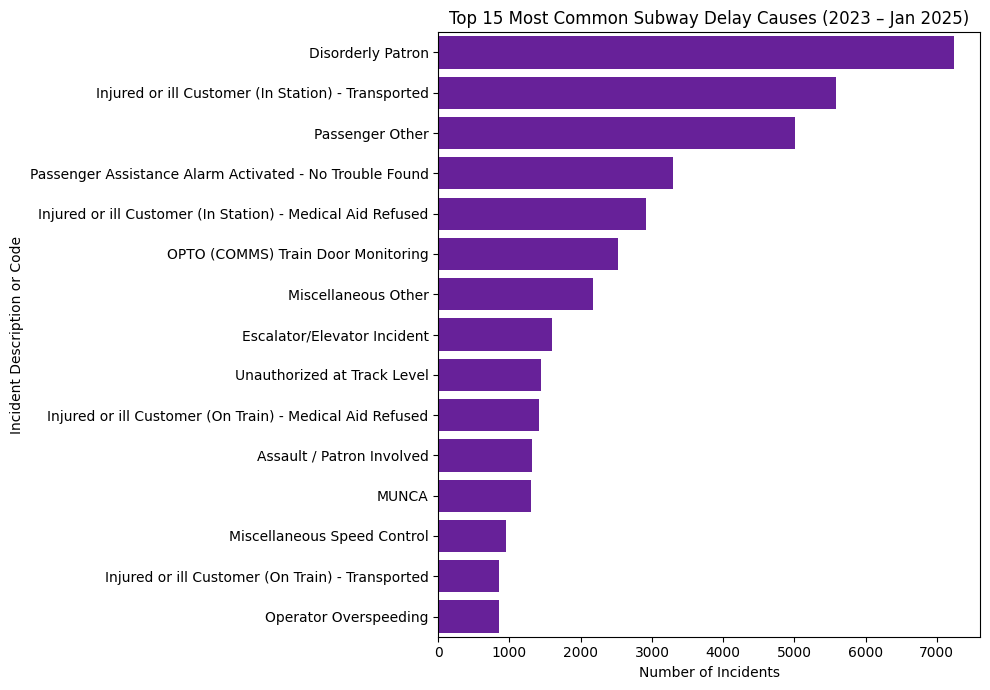

In [21]:
# use 'Code Description' if available, otherwise fall back to 'Code'
subway_all_clean['Display Label'] = subway_all_clean['Code Description'].fillna(subway_all_clean['Code'])

# drop empty or purely whitespace labels to avoid bad entries
subway_all_clean['Display Label'] = subway_all_clean['Display Label'].replace(r'^\s*$', np.nan, regex=True)
subway_all_clean = subway_all_clean.dropna(subset=['Display Label'])

# Top 15 most frequent delay causes
top_15 = subway_all_clean['Display Label'].value_counts().nlargest(15)

# horizontal bar chart
plt.figure(figsize=(10, 7))
sns.barplot(
    y=top_15.index,
    x=top_15.values,
    hue=top_15.index,
    palette=['#6A0DAD'] * len(top_15),
    legend=False
)

plt.title("Top 15 Most Common Subway Delay Causes (2023 – Jan 2025)")
plt.xlabel("Number of Incidents")
plt.ylabel("Incident Description or Code")
plt.tight_layout()
plt.show()


Let's also look at the stations across different modes of transportation, as well as bust routes with the highest incident frequency:

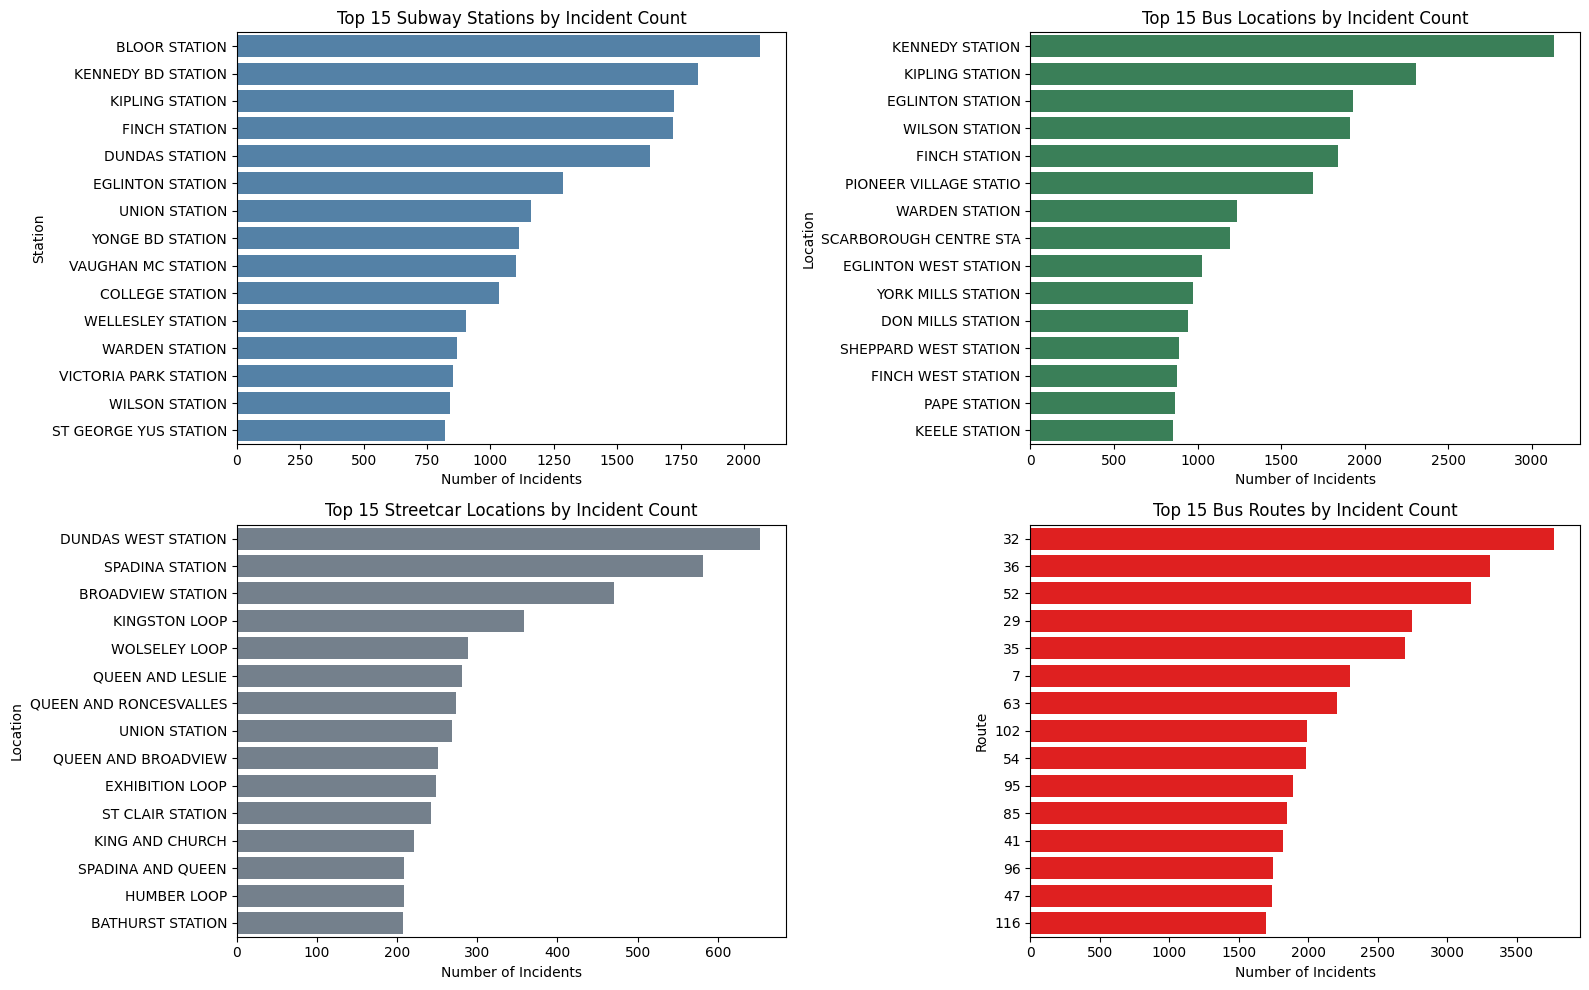

In [22]:
plt.figure(figsize=(16, 10))

# colours
colors = ['steelblue', 'seagreen', 'slategray', 'red']

# Top 15 subway stations
top_subway_stations = subway_all_clean['Station'].value_counts().head(15)
plt.subplot(2, 2, 1)
sns.barplot(x=top_subway_stations.values, y=top_subway_stations.index, color=colors[0])
plt.title("Top 15 Subway Stations by Incident Count")
plt.xlabel("Number of Incidents")
plt.ylabel("Station")

# Top 15 bus stations
top_bus_stations = bus_all_clean['Location'].value_counts().head(15)
plt.subplot(2, 2, 2)
sns.barplot(x=top_bus_stations.values, y=top_bus_stations.index, color=colors[1])
plt.title("Top 15 Bus Locations by Incident Count")
plt.xlabel("Number of Incidents")
plt.ylabel("Location")

# Top 15 streetcar stations
top_streetcar_stations = streetcar_all_clean['Location'].value_counts().head(15)
plt.subplot(2, 2, 3)
sns.barplot(x=top_streetcar_stations.values, y=top_streetcar_stations.index, color=colors[2])
plt.title("Top 15 Streetcar Locations by Incident Count")
plt.xlabel("Number of Incidents")
plt.ylabel("Location")

# Top 15 bus routes
top_routes = bus_all_clean['Route'].value_counts().head(15)
plt.subplot(2, 2, 4)
sns.barplot(x=top_routes.values, y=top_routes.index.astype(str), color=colors[3])
plt.title("Top 15 Bus Routes by Incident Count")
plt.xlabel("Number of Incidents")
plt.ylabel("Route")

filename = "incident_counts_per_stations_and_route.png"
plt.savefig(filename, dpi=300)

plt.tight_layout()
plt.show()

Next, let's examine the distributions of Min Delay and Min Gap values. We'll visualize these distributions separately for each transit mode and each year to observe patterns clearly:

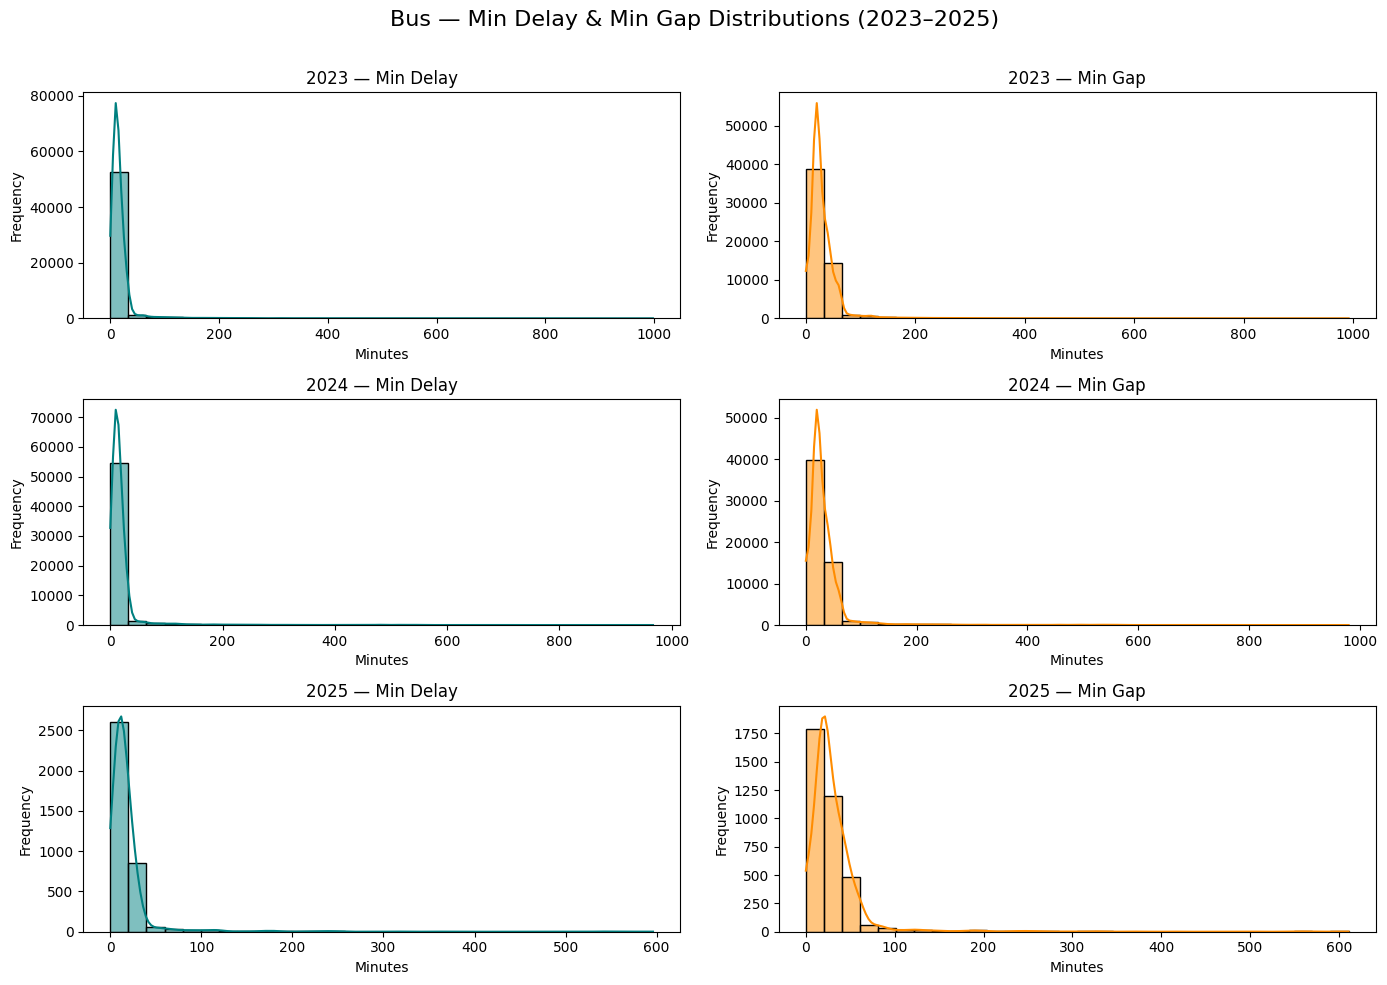

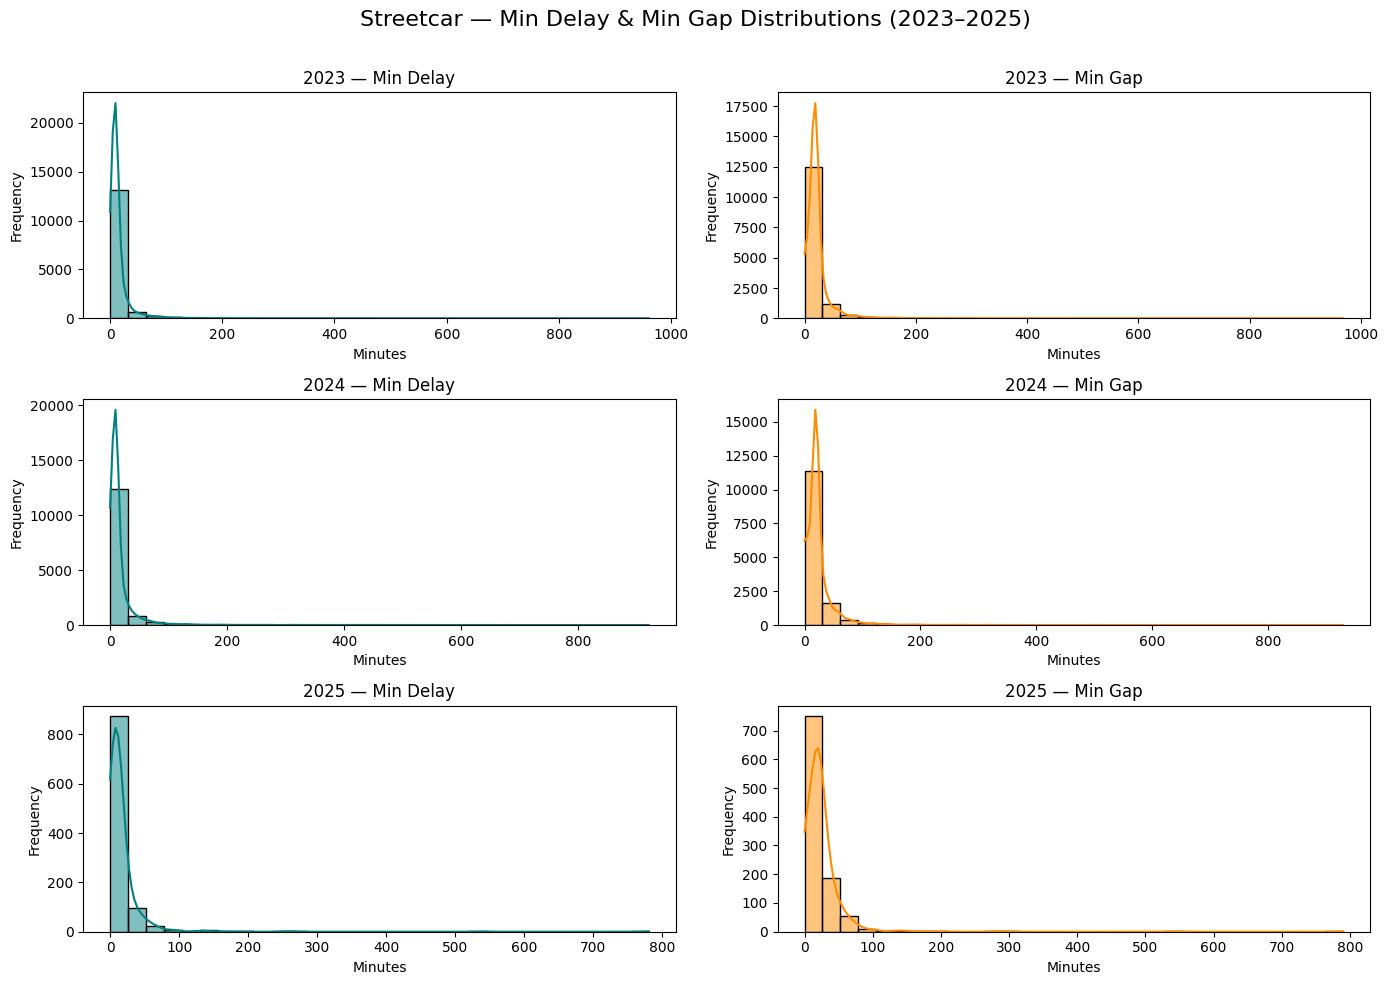

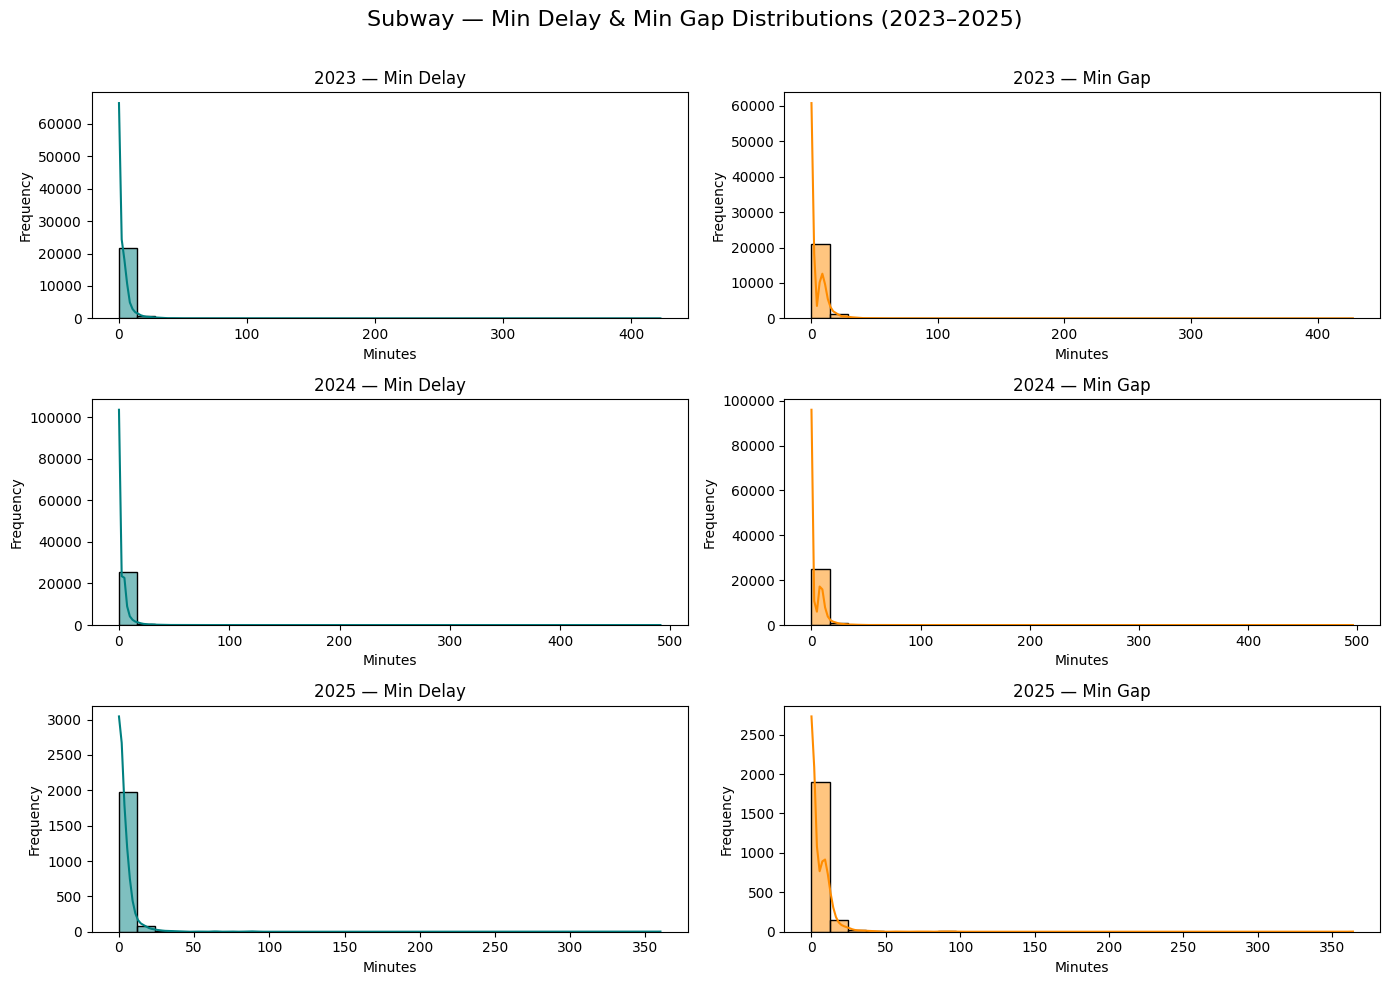

In [23]:
def plot_delay_gap_grid(cleaned_dfs, mode):
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f"{mode} — Min Delay & Min Gap Distributions (2023–2025)", fontsize=16)
    
    years = ['2023', '2024', '2025']
    for i, (year, df) in enumerate(zip(years, cleaned_dfs)):
        # Min Delay
        sns.histplot(df['Min Delay'], bins=30, ax=axes[i, 0], kde=True, color='teal')
        axes[i, 0].set_title(f"{year} — Min Delay")
        axes[i, 0].set_xlabel("Minutes")
        axes[i, 0].set_ylabel("Frequency")

        # Min Gap
        sns.histplot(df['Min Gap'], bins=30, ax=axes[i, 1], kde=True, color='darkorange')
        axes[i, 1].set_title(f"{year} — Min Gap")
        axes[i, 1].set_xlabel("Minutes")
        axes[i, 1].set_ylabel("Frequency")


    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Add space for suptitle
    plt.show()

# Plot for each mode
plot_delay_gap_grid([bus_2023_clean, bus_2024_clean, bus_2025_clean], "Bus")
plot_delay_gap_grid([streetcar_2023_clean, streetcar_2024_clean, streetcar_2025_clean], "Streetcar")
plot_delay_gap_grid([subway_2023_clean, subway_2024_clean, subway_2025_clean], "Subway")


Since the results appear to be quite skewed due to rare but extreme delays stretching the x-axis, let's add an upper bound for the maximum values of Min Delay and Min Gap. This helps us better understand the distribution of more common, short-to-moderate delays that make up the majority of TTC records:

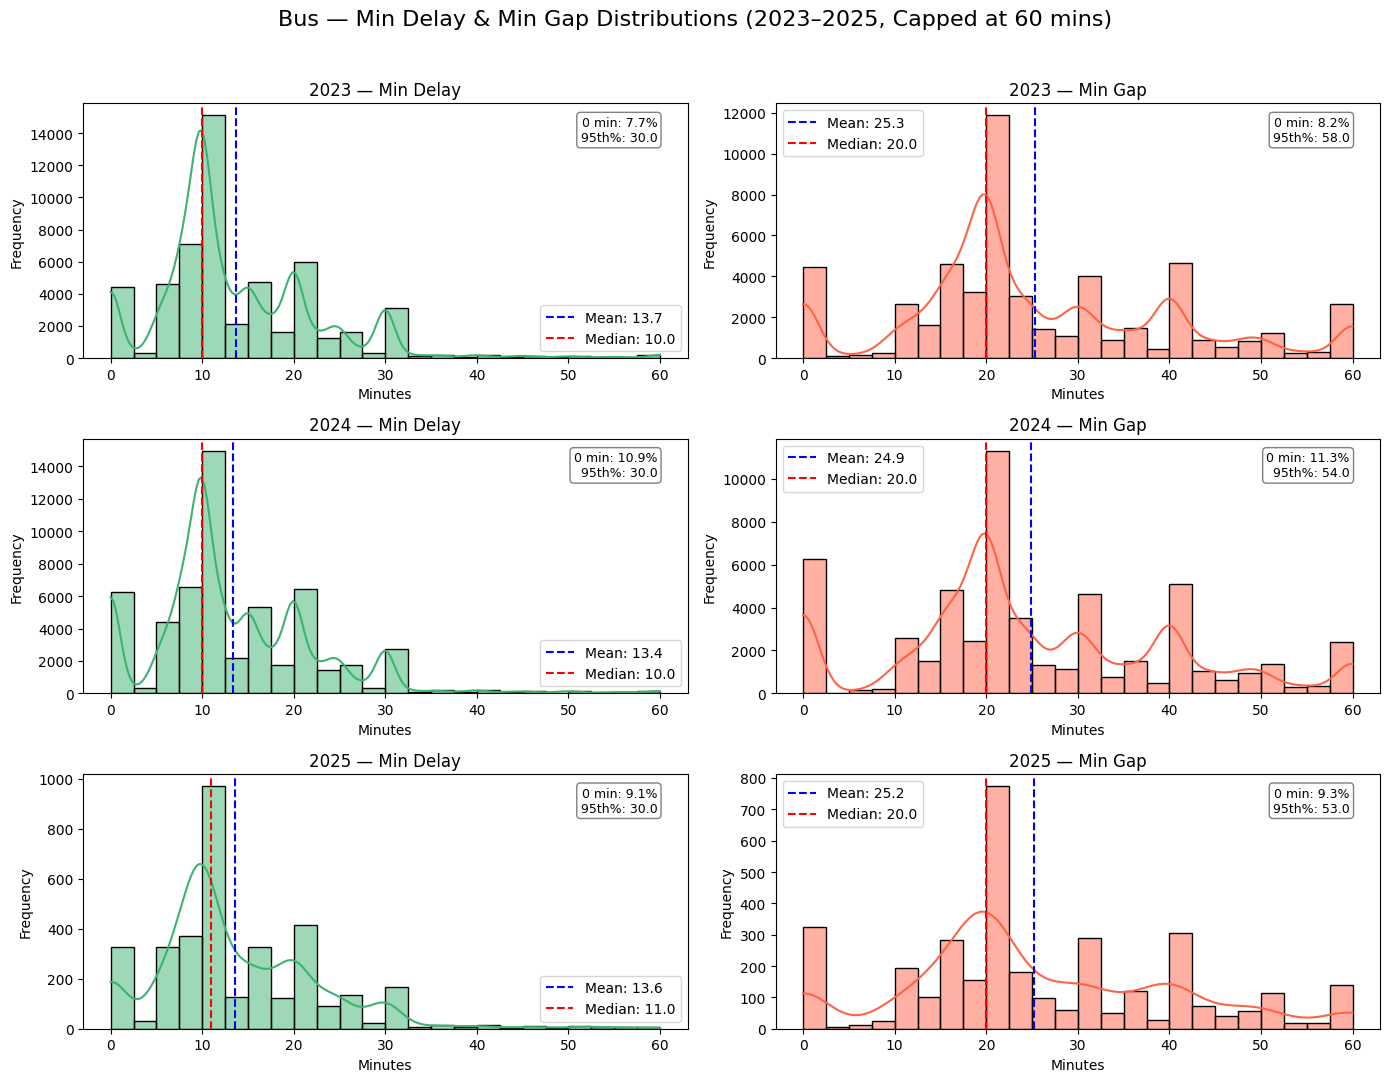

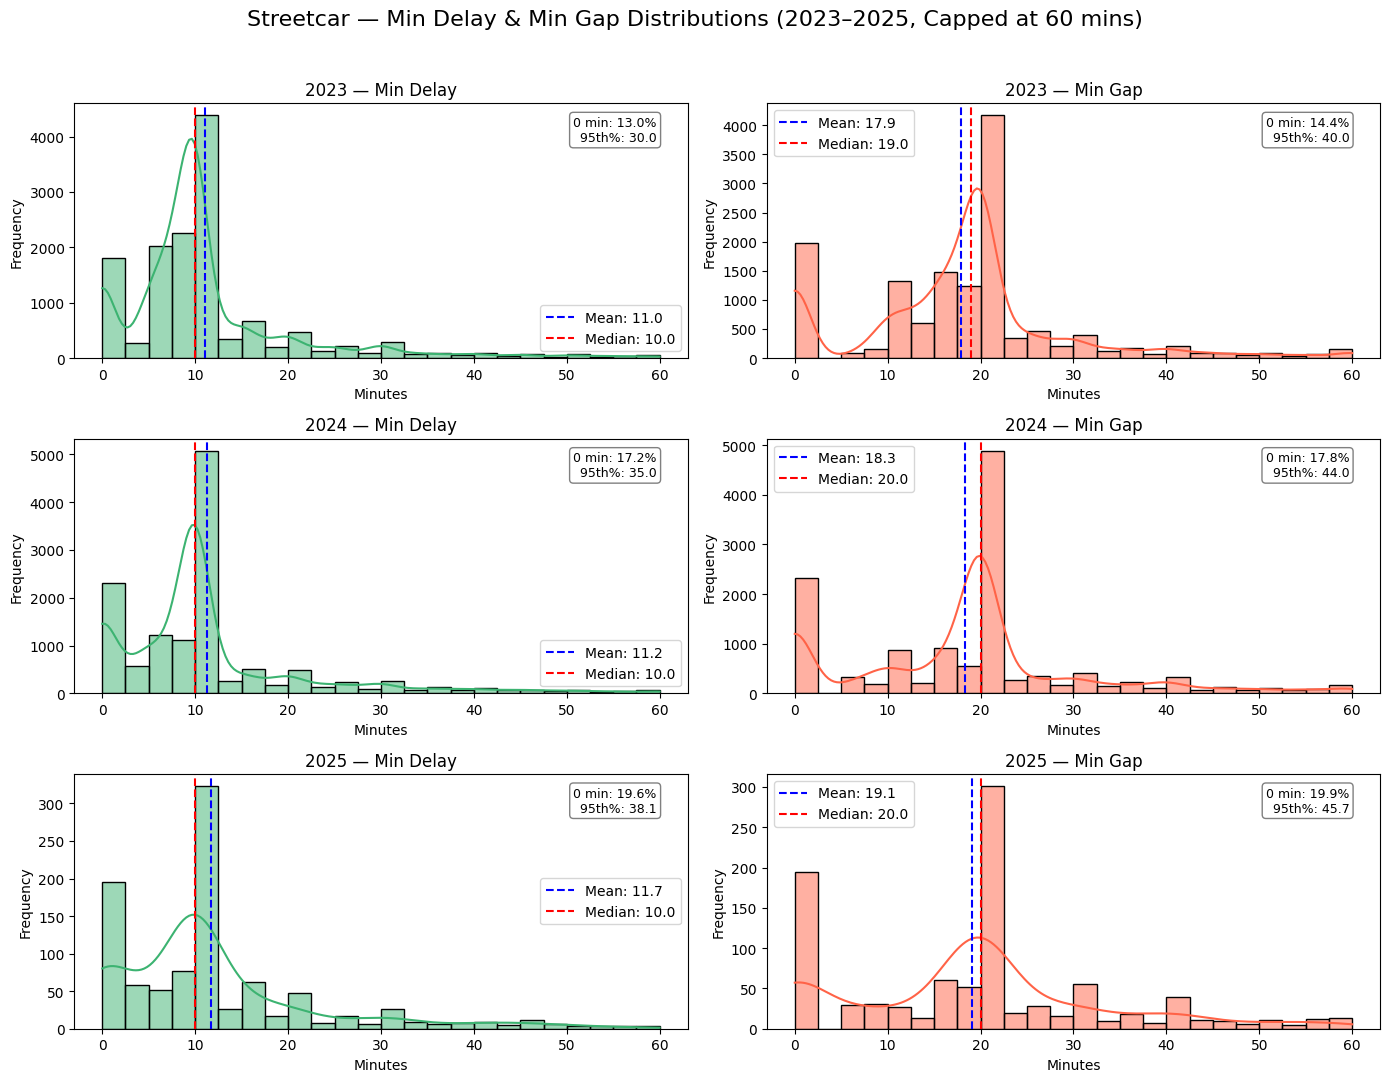

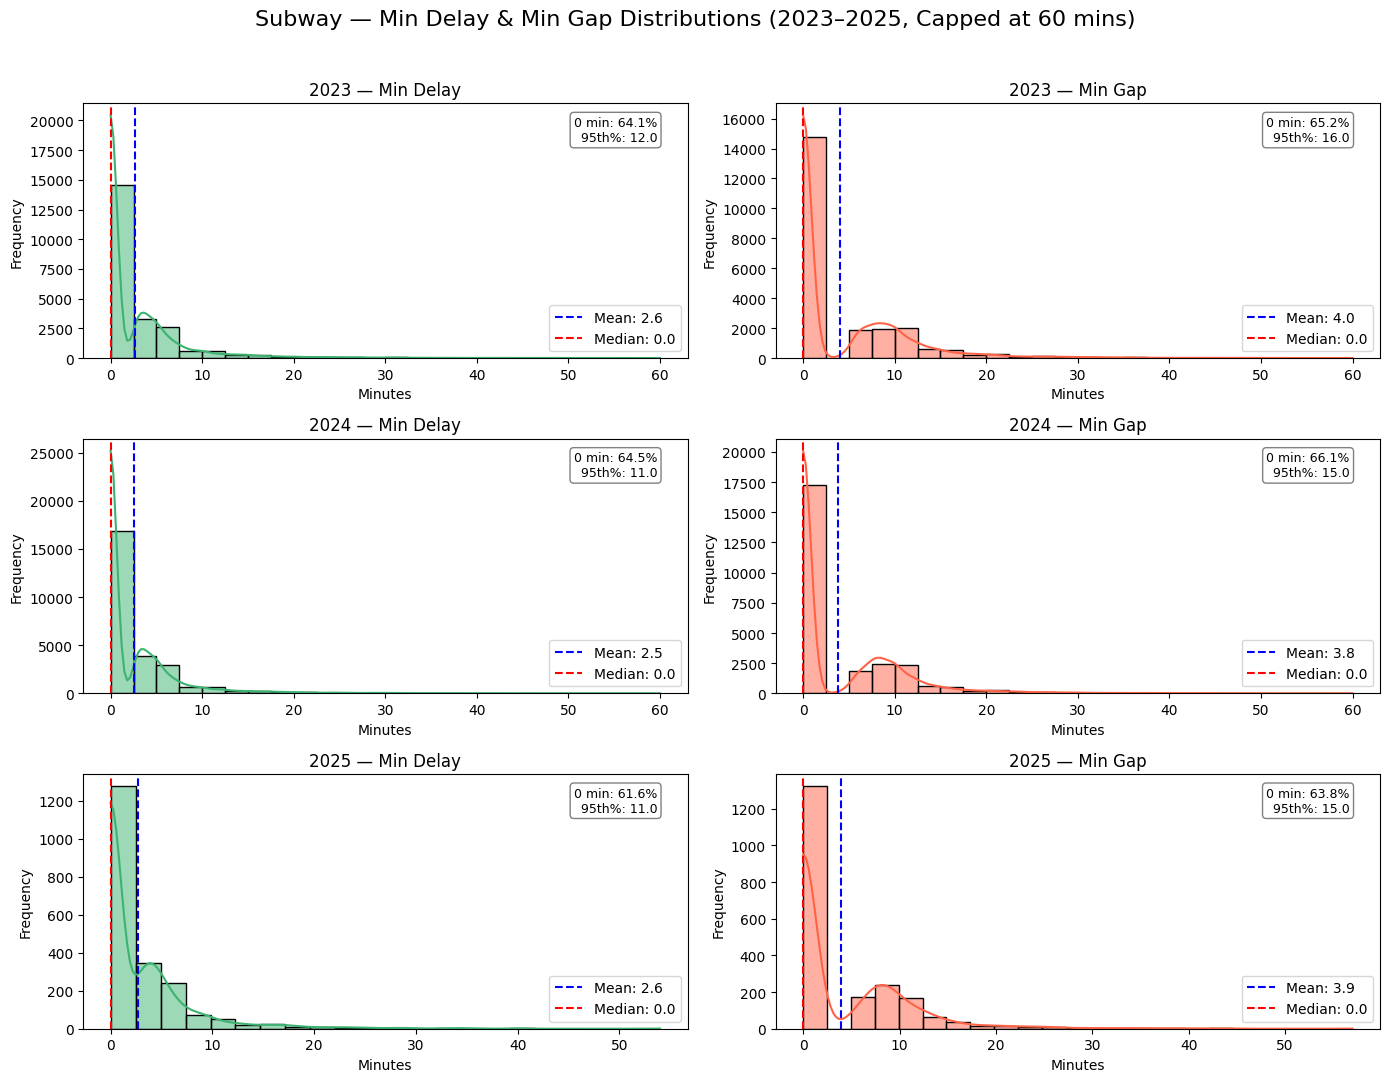

In [24]:
def plot_delay_gap_grid_enhanced(cleaned_dfs, mode, cap=60):

    fig, axes = plt.subplots(3, 2, figsize=(14, 11))
    fig.suptitle(f"{mode} — Min Delay & Min Gap Distributions (2023–2025, Capped at {cap} mins)", fontsize=16)

    years = ['2023', '2024', '2025']
    for i, (year, df) in enumerate(zip(years, cleaned_dfs)):
        # Cap the data
        delay = df[df['Min Delay'] <= cap]['Min Delay']
        gap = df[df['Min Gap'] <= cap]['Min Gap']

        # Delay stats
        delay_mean = delay.mean()
        delay_median = delay.median()
        delay_zero_pct = (delay == 0).mean() * 100
        delay_95th = np.percentile(delay, 95)

        # Gap stats
        gap_mean = gap.mean()
        gap_median = gap.median()
        gap_zero_pct = (gap == 0).mean() * 100
        gap_95th = np.percentile(gap, 95)

        # Plot Min Delay
        sns.histplot(delay, binwidth=2.5, ax=axes[i, 0], kde=True, color='mediumseagreen')
        axes[i, 0].axvline(delay_mean, color='blue', linestyle='--', label=f"Mean: {delay_mean:.1f}")
        axes[i, 0].axvline(delay_median, color='red', linestyle='--', label=f"Median: {delay_median:.1f}")
        axes[i, 0].set_title(f"{year} — Min Delay")
        axes[i, 0].set_xlabel("Minutes")
        axes[i, 0].set_ylabel("Frequency")
        axes[i, 0].legend()
        axes[i, 0].text(0.95, 0.95,
                        f"0 min: {delay_zero_pct:.1f}%\n95th%: {delay_95th:.1f}",
                        ha='right', va='top', transform=axes[i, 0].transAxes,
                        fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

        # Plot Min Gap
        sns.histplot(gap, binwidth=2.5, ax=axes[i, 1], kde=True, color='tomato')
        axes[i, 1].axvline(gap_mean, color='blue', linestyle='--', label=f"Mean: {gap_mean:.1f}")
        axes[i, 1].axvline(gap_median, color='red', linestyle='--', label=f"Median: {gap_median:.1f}")
        axes[i, 1].set_title(f"{year} — Min Gap")
        axes[i, 1].set_xlabel("Minutes")
        axes[i, 1].set_ylabel("Frequency")
        axes[i, 1].legend()
        axes[i, 1].text(0.95, 0.95,
                        f"0 min: {gap_zero_pct:.1f}%\n95th%: {gap_95th:.1f}",
                        ha='right', va='top', transform=axes[i, 1].transAxes,
                        fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_delay_gap_grid_enhanced([bus_2023_clean, bus_2024_clean, bus_2025_clean], "Bus", cap=60)
plot_delay_gap_grid_enhanced([streetcar_2023_clean, streetcar_2024_clean, streetcar_2025_clean], "Streetcar", cap=60)
plot_delay_gap_grid_enhanced([subway_2023_clean, subway_2024_clean, subway_2025_clean], "Subway", cap=60)

Save 2024 graphs for the project report:

In [25]:
def plot_single_year_delay_gap(df, mode, year='2024', cap=60):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f"{mode} — Min Delay & Min Gap Distributions ({year}, Capped at {cap} mins)", fontsize=16)

    delay = df[df['Min Delay'] <= cap]['Min Delay']
    gap = df[df['Min Gap'] <= cap]['Min Gap']

    delay_mean = delay.mean()
    delay_median = delay.median()
    delay_zero_pct = (delay == 0).mean() * 100
    delay_95th = np.percentile(delay, 95)

    gap_mean = gap.mean()
    gap_median = gap.median()
    gap_zero_pct = (gap == 0).mean() * 100
    gap_95th = np.percentile(gap, 95)

    # plot Min Delay
    sns.histplot(delay, binwidth=2.5, ax=ax1, kde=True, color='mediumseagreen')
    ax1.axvline(delay_mean, color='blue', linestyle='--', label=f"Mean: {delay_mean:.1f}")
    ax1.axvline(delay_median, color='red', linestyle='--', label=f"Median: {delay_median:.1f}")
    ax1.set_title(f"{year} — Min Delay")
    ax1.set_xlabel("Minutes")
    ax1.set_ylabel("Frequency")
    ax1.legend()
    ax1.text(0.95, 0.95,
             f"0 min: {delay_zero_pct:.1f}%\n95th%: {delay_95th:.1f}",
             ha='right', va='top', transform=ax1.transAxes,
             fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

    # plot Min Gap
    sns.histplot(gap, binwidth=2.5, ax=ax2, kde=True, color='tomato')
    ax2.axvline(gap_mean, color='blue', linestyle='--', label=f"Mean: {gap_mean:.1f}")
    ax2.axvline(gap_median, color='red', linestyle='--', label=f"Median: {gap_median:.1f}")
    ax2.set_title(f"{year} — Min Gap")
    ax2.set_xlabel("Minutes")
    ax2.set_ylabel("Frequency")
    ax2.legend()
    ax2.text(0.95, 0.95,
             f"0 min: {gap_zero_pct:.1f}%\n95th%: {gap_95th:.1f}",
             ha='right', va='top', transform=ax2.transAxes,
             fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1))

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(f'{mode.lower()}_2024_delay_gap.png', dpi=300, bbox_inches='tight')
    plt.close()


plot_single_year_delay_gap(bus_2024_clean, "Bus")
plot_single_year_delay_gap(streetcar_2024_clean, "Streetcar")
plot_single_year_delay_gap(subway_2024_clean, "Subway")

Now, let's explore Station-specific delays using a scatterplot, with coloured bubbles to capture 4 different qulities: min delay, min gap, incident frequency and show on which line the station is located.

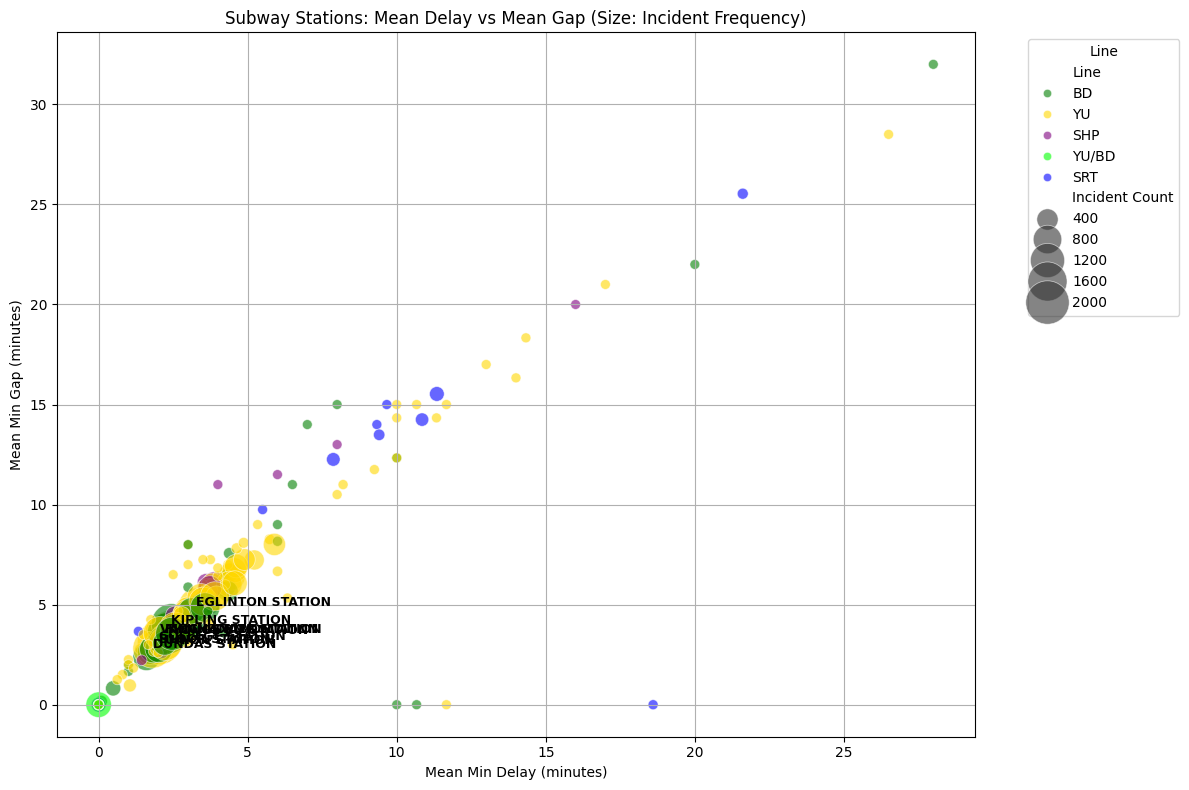

In [26]:
# aggregation for Subway data
subway_station_stats = subway_all_clean.groupby(['Station', 'Line']).agg({
    'Min Delay': 'mean',
    'Min Gap': 'mean',
    'Station': 'count'
}).rename(columns={'Station': 'Incident Count'}).reset_index()

# colour mapping for subway lines
line_colours = {
    'YU': 'gold',
    'BD': 'green',
    'SHP': 'purple',
    'SRT': 'blue',
    'YU/BD': 'lime'
}

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=subway_station_stats,
    x='Min Delay',
    y='Min Gap',
    size='Incident Count',
    hue='Line',
    palette=line_colours,
    sizes=(50, 1000),
    alpha=0.6,
    legend='brief'
)

# annotate top incident stations
top_stations = subway_station_stats.sort_values('Incident Count', ascending=False).head(10)
for _, row in top_stations.iterrows():
    plt.text(row['Min Delay'], row['Min Gap'], row['Station'], fontsize=9, weight='bold')

plt.title('Subway Stations: Mean Delay vs Mean Gap (Size: Incident Frequency)')
plt.xlabel('Mean Min Delay (minutes)')
plt.ylabel('Mean Min Gap (minutes)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Seems like a not very good representation due to high correlation between Gap/Delay, let's check their correlation:

Bus — Correlation between Min Delay and Min Gap: 0.96


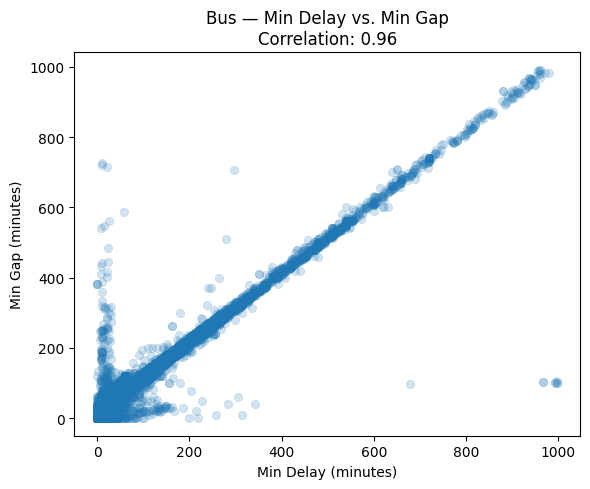

Streetcar — Correlation between Min Delay and Min Gap: 0.95


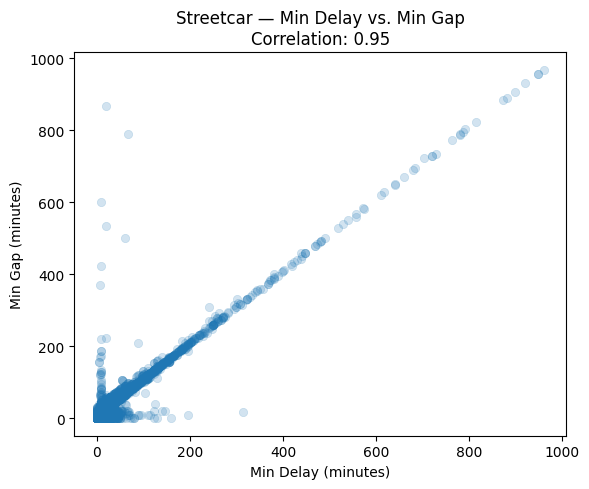

Subway — Correlation between Min Delay and Min Gap: 0.95


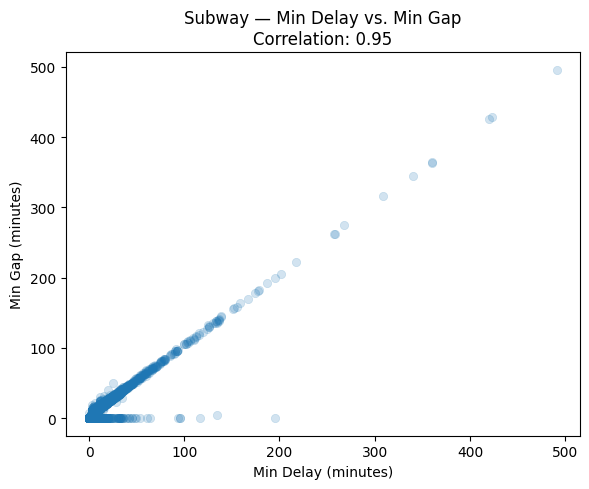

In [46]:
def delay_gap_correlation(df, mode):
    # drop rows with missing values in either column
    df_filtered = df[['Min Delay', 'Min Gap']].dropna()

    corr = df_filtered['Min Delay'].corr(df_filtered['Min Gap'])
    print(f"{mode} — Correlation between Min Delay and Min Gap: {corr:.2f}")

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df_filtered,
        x='Min Delay',
        y='Min Gap',
        alpha=0.2,
        edgecolor=None
    )
    plt.title(f"{mode} — Min Delay vs. Min Gap\nCorrelation: {corr:.2f}")
    plt.xlabel("Min Delay (minutes)")
    plt.ylabel("Min Gap (minutes)")
    plt.tight_layout()
    plt.show()

# Example: run for subway, streetcar, and bus
delay_gap_correlation(bus_all_clean, "Bus")
delay_gap_correlation(streetcar_all_clean, "Streetcar")
delay_gap_correlation(subway_all_clean, "Subway")

Considering this high correlation, a more interesting choice for Station-specific delays visualisation would be to recreate the bubble scatter plot from before while swapping Delay and Frequency:

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


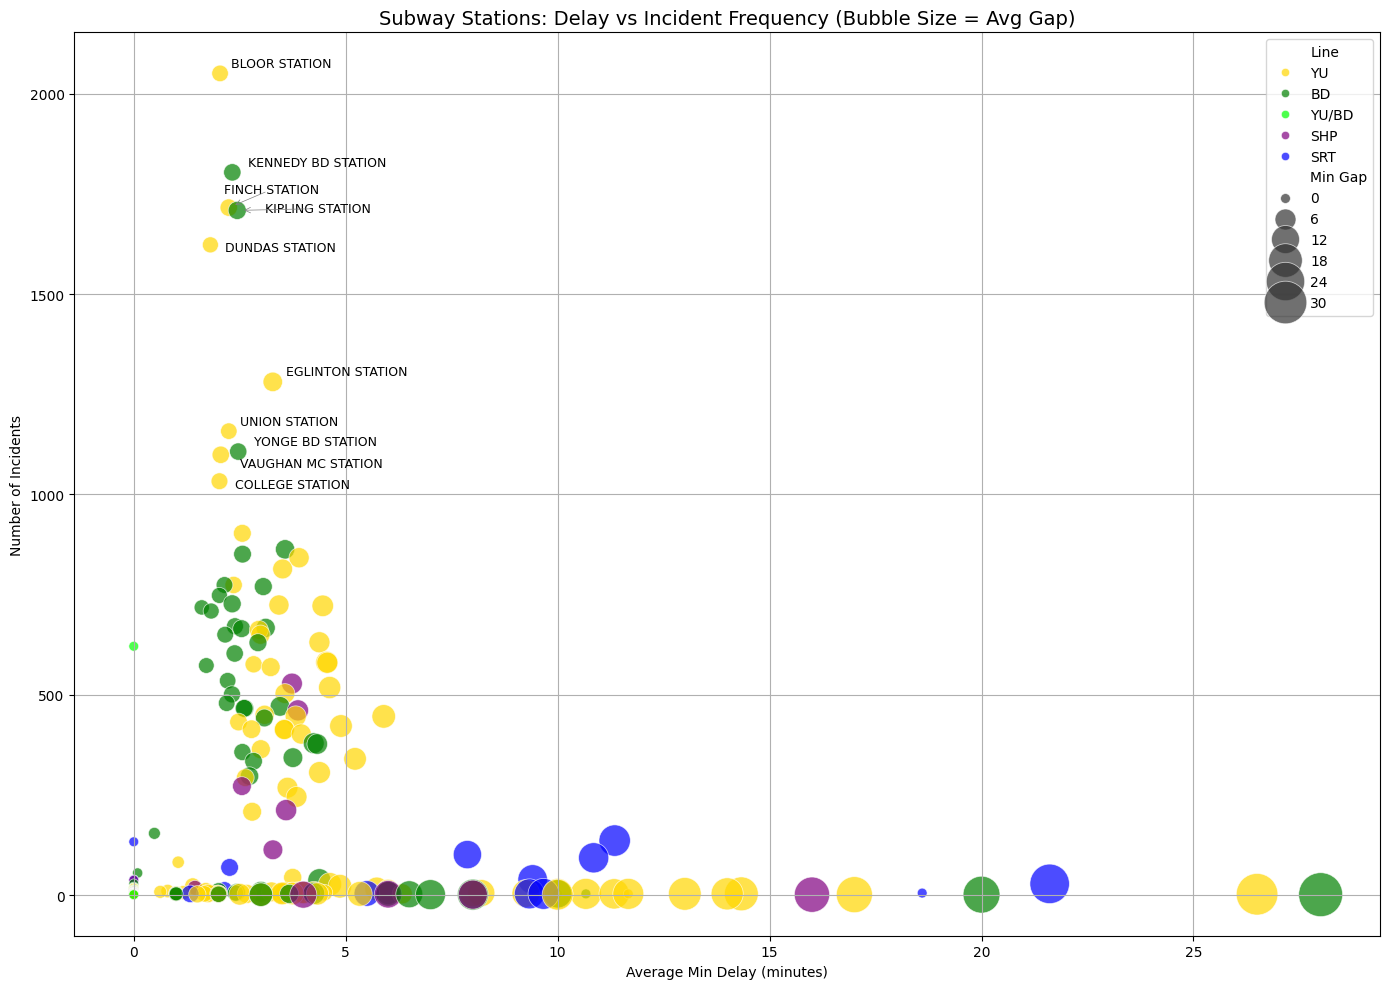

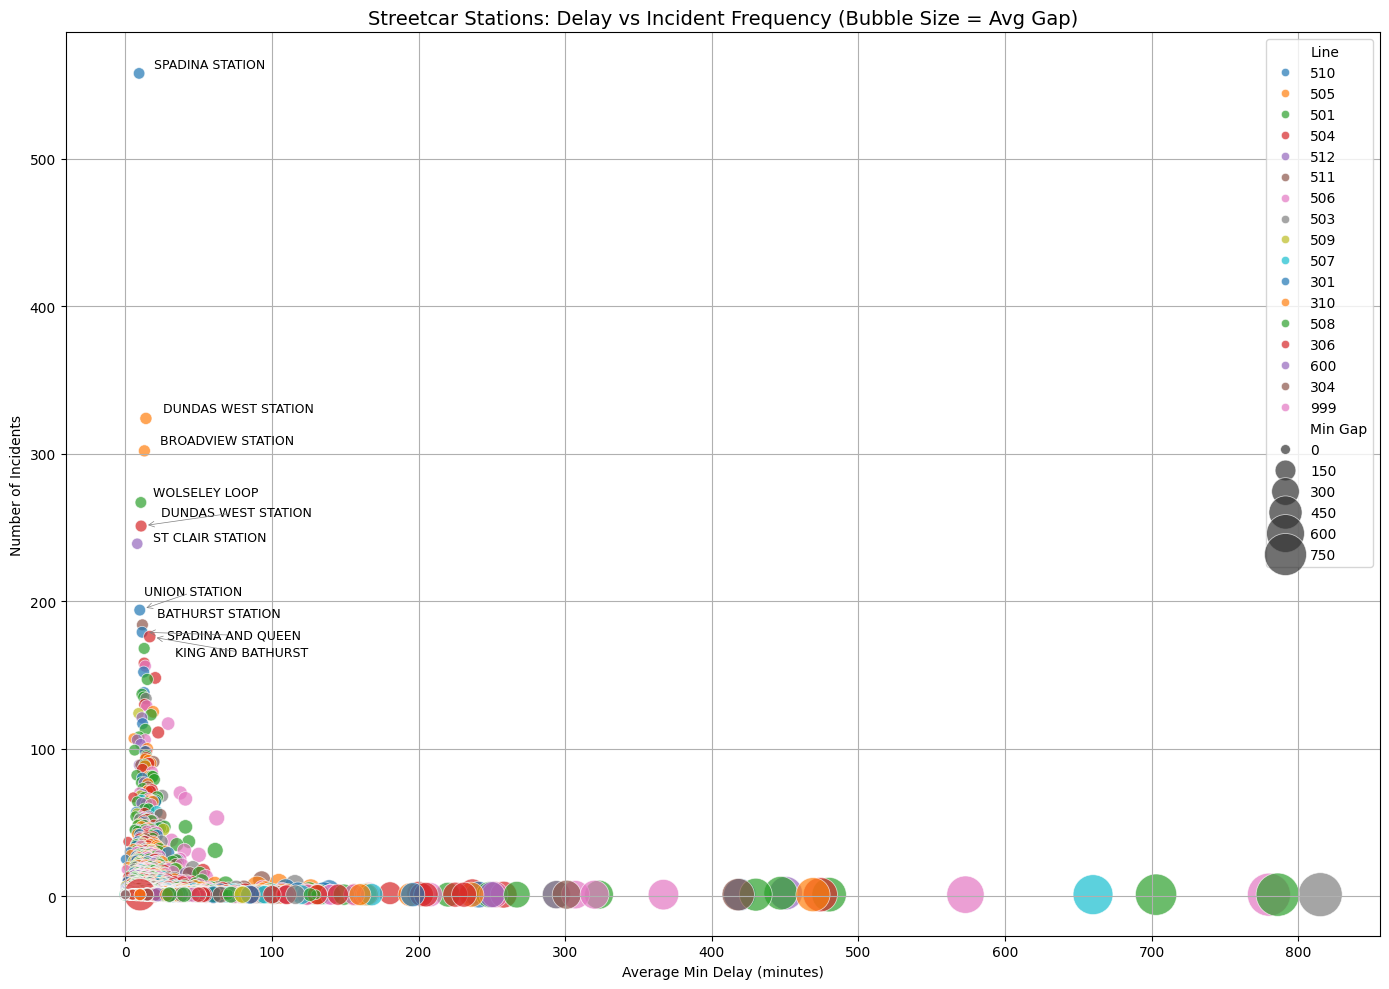

In [27]:
def plot_station_level_scatter(df, mode='Subway', station_col='Station'):

    grouped = df.groupby([station_col, 'Line']).agg({
        'Min Delay': 'mean',
        'Min Gap': 'mean',
        station_col: 'count'
    }).rename(columns={station_col: 'Incident Count'}).reset_index()

    # Sort by most incidents
    grouped = grouped.sort_values('Incident Count', ascending=False)

    plt.figure(figsize=(14, 10))
    # subway line colours for subway
    palette = line_colours if mode == 'Subway' else 'tab10'
    scatter = sns.scatterplot(
        data=grouped,
        x='Min Delay',
        y='Incident Count',
        size='Min Gap',
        hue='Line',
        sizes=(50, 1000),
        palette=palette,
        alpha=0.7,
        legend='brief'
    )

    # annotate top 10 busiest stations
    texts = []
    for _, row in grouped.head(10).iterrows():
        texts.append(plt.text(row['Min Delay'], row['Incident Count'], 
                            row[station_col], fontsize=9))

    # adjust text positions to avoid overlaps
    adjust_text(texts, 
               arrowprops=dict(arrowstyle='->', color='gray', lw=0.5, shrinkA=5, shrinkB=5),
               expand_points=(2, 2),
               force_points=(0.1, 0.1),
               force_text=(0.2, 0.2),
               only_move={'points':'y', 'text':'xy'})

    plt.title(f'{mode} Stations: Delay vs Incident Frequency (Bubble Size = Avg Gap)', fontsize=14)
    plt.xlabel('Average Min Delay (minutes)')
    plt.ylabel('Number of Incidents')
    plt.grid(True)
    plt.tight_layout()
    filename = f'{mode.lower()}_station_level_scatter.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# subway
plot_station_level_scatter(subway_all_clean, mode='Subway', station_col='Station')

# streetcar
plot_station_level_scatter(streetcar_all_clean, mode='Streetcar', station_col='Location')

Let's also look at a similar plot, but for subway/street car lines instead of stations:

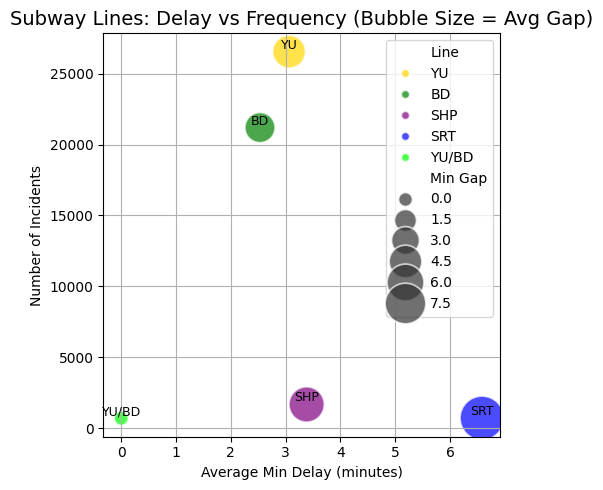

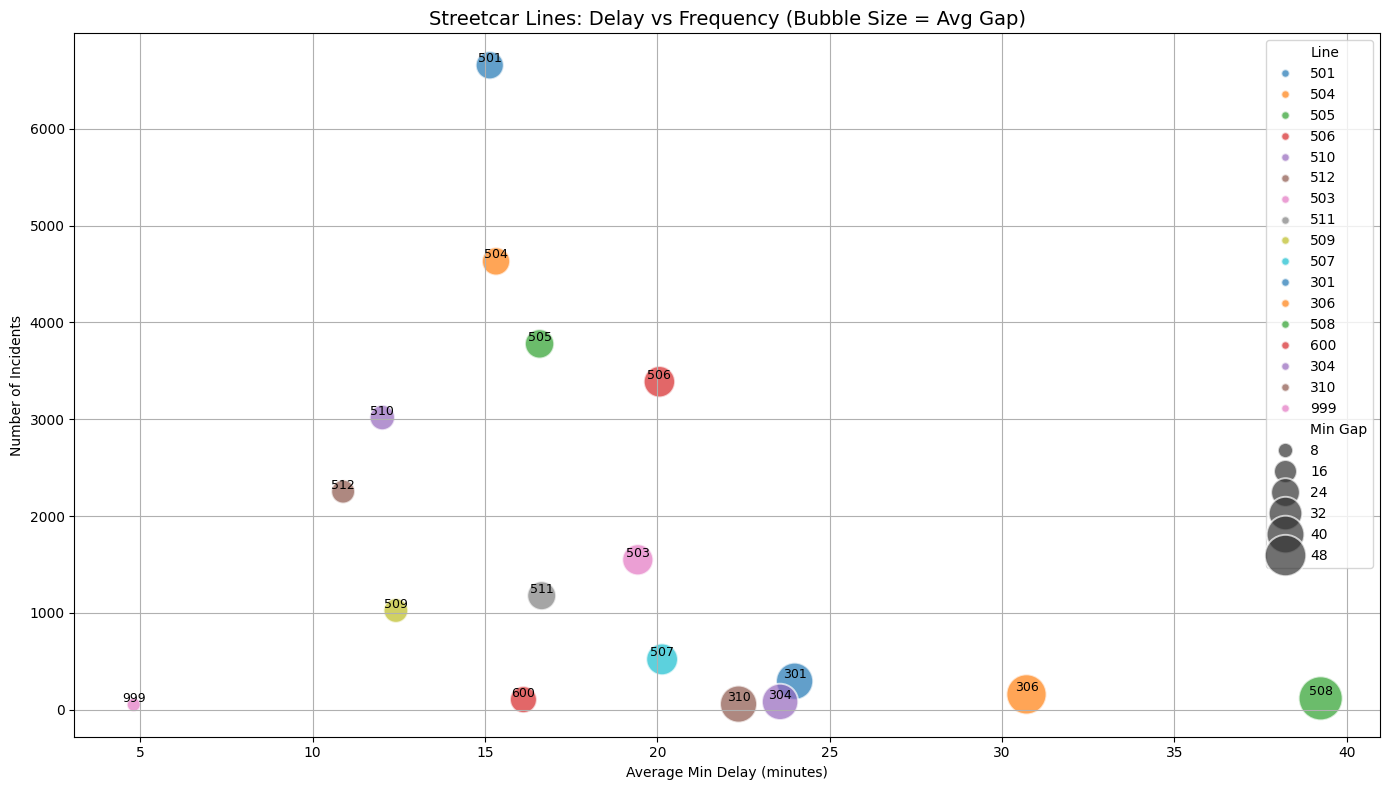

In [28]:
def plot_line_level_delay_scatter(df, mode='Subway'):
    # group by Line
    grouped = df.groupby('Line').agg({
        'Min Delay': 'mean',
        'Min Gap': 'mean',
        'Line': 'count'
    }).rename(columns={'Line': 'Incident Count'}).reset_index()

    # sorting for nicer legends
    grouped = grouped.sort_values('Incident Count', ascending=False)

    # use line_colours for subway mode, otherwise use default palette
    palette = line_colours if mode == 'Subway' else 'tab10'
    # larger figure size for streetcars, as they have more lines:
    plot_size = (5, 5) if mode == 'Subway' else (14, 8)
    plt.figure(figsize=plot_size)
    
    scatter = sns.scatterplot(
        data=grouped,
        x='Min Delay',
        y='Incident Count',
        size='Min Gap',
        hue='Line',
        sizes=(100, 1000),
        palette=palette,
        alpha=0.7,
        legend='brief'
    )

    for i, row in grouped.iterrows():
        plt.text(row['Min Delay'], row['Incident Count'], row['Line'], fontsize=9,
                 ha='center', va='bottom')

    plt.title(f'{mode} Lines: Delay vs Frequency (Bubble Size = Avg Gap)', fontsize=14)
    plt.xlabel('Average Min Delay (minutes)')
    plt.ylabel('Number of Incidents')
    plt.grid(True)
    plt.tight_layout()

    filename = f'{mode.lower()}_line_level_delay_scatter.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

# subway
plot_line_level_delay_scatter(subway_all_clean, mode='Subway')

# streetcar
plot_line_level_delay_scatter(streetcar_all_clean, mode='Streetcar')


Another interesting thing to look at is the hour of day for which the incidents occur; a good way to show that would be to use a radial chart with "pie" pieces' length indicating delay frequency and their colour indicating average delay gap:

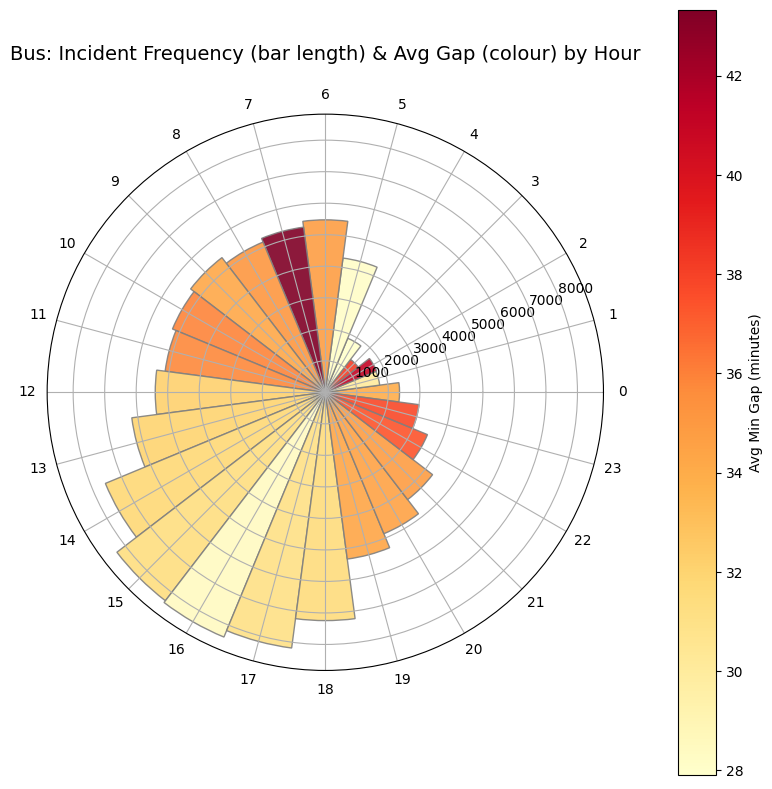

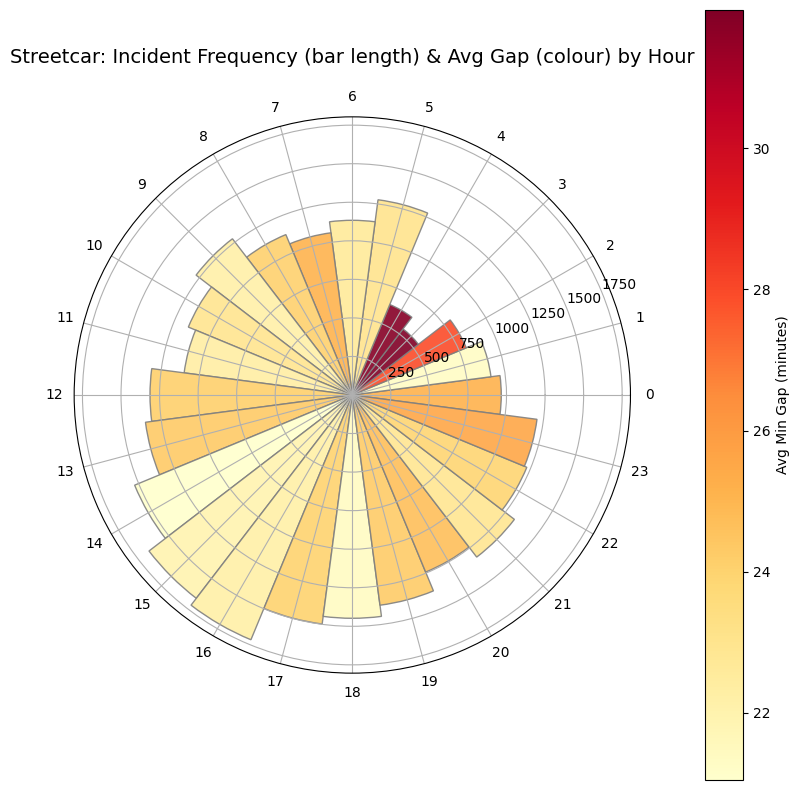

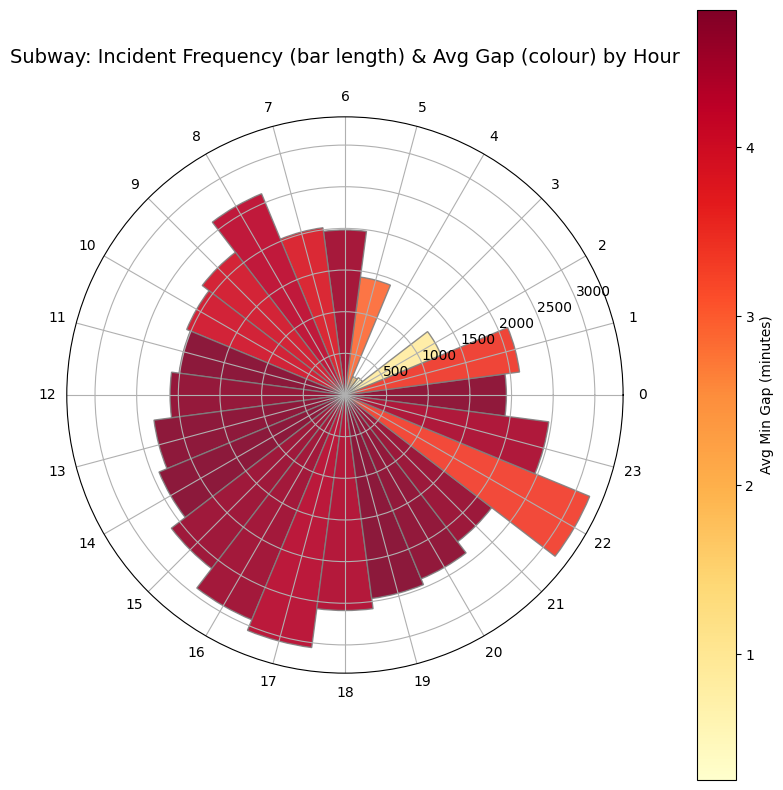

In [56]:
def plot_hourly_radial_colored(df, mode):
    # make a copy and convert time
    df = df.copy()
    df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour  # format is explicit now

def plot_hourly_radial_colored(df, mode):
    # make a copy and convert time
    df = df.copy()
    df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour  # format is explicit now

    # compute hourly counts and averages
    hourly = df.groupby('Hour').agg({
        'Min Delay': 'count',  # count of incidents
        'Min Gap': 'mean'      # average gap
    }).reindex(range(24), fill_value=0)

    # set up polar coordinates
    theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)
    radii = hourly['Min Delay'].values  # now using count for bar length
    gap_values = hourly['Min Gap'].values

    # normalize for color mapping
    norm = plt.Normalize(gap_values.min(), gap_values.max())
    colors = plt.cm.YlOrRd(norm(gap_values))
    width = (2 * np.pi) / 24

    # create polar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    bars = ax.bar(theta, radii, width=width, bottom=0.0, color=colors, edgecolor='gray', alpha=0.9)

    ax.set_xticks(theta)
    ax.set_xticklabels(range(24))
    ax.set_title(f'{mode}: Incident Frequency (bar length) & Avg Gap (colour) by Hour', fontsize=14, pad=20)

    # add colorbar to the same figure + axis
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.1)
    cbar.set_label('Avg Min Gap (minutes)')

    filename = f'{mode.lower()}_frequency_gap_by_hour.png'
    plt.savefig(filename, dpi=300, pad_inches=0.3)

    plt.tight_layout()
    plt.show()



plot_hourly_radial_colored(bus_all_clean, 'Bus')
plot_hourly_radial_colored(streetcar_all_clean, 'Streetcar')
plot_hourly_radial_colored(subway_all_clean, 'Subway')

Let's also break it down by incident type for streetcars and busses:

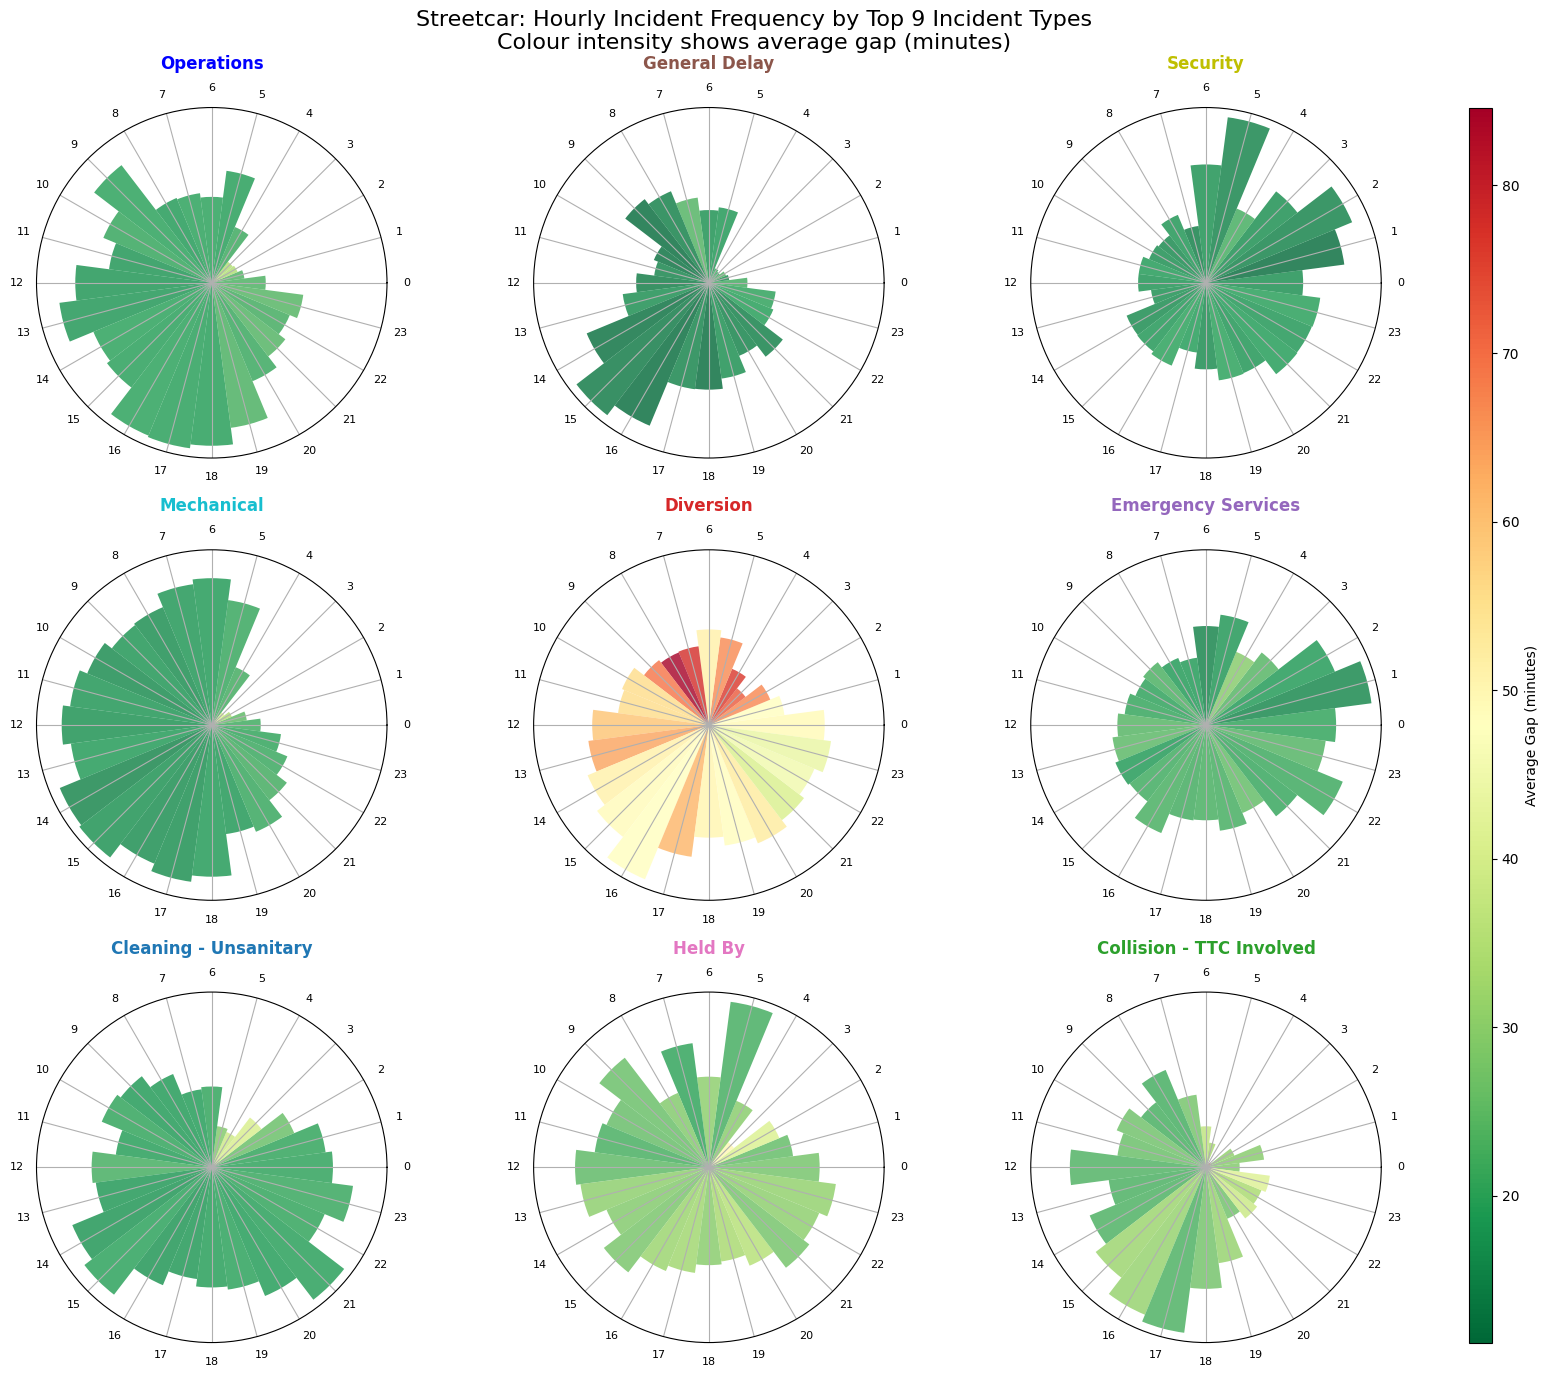

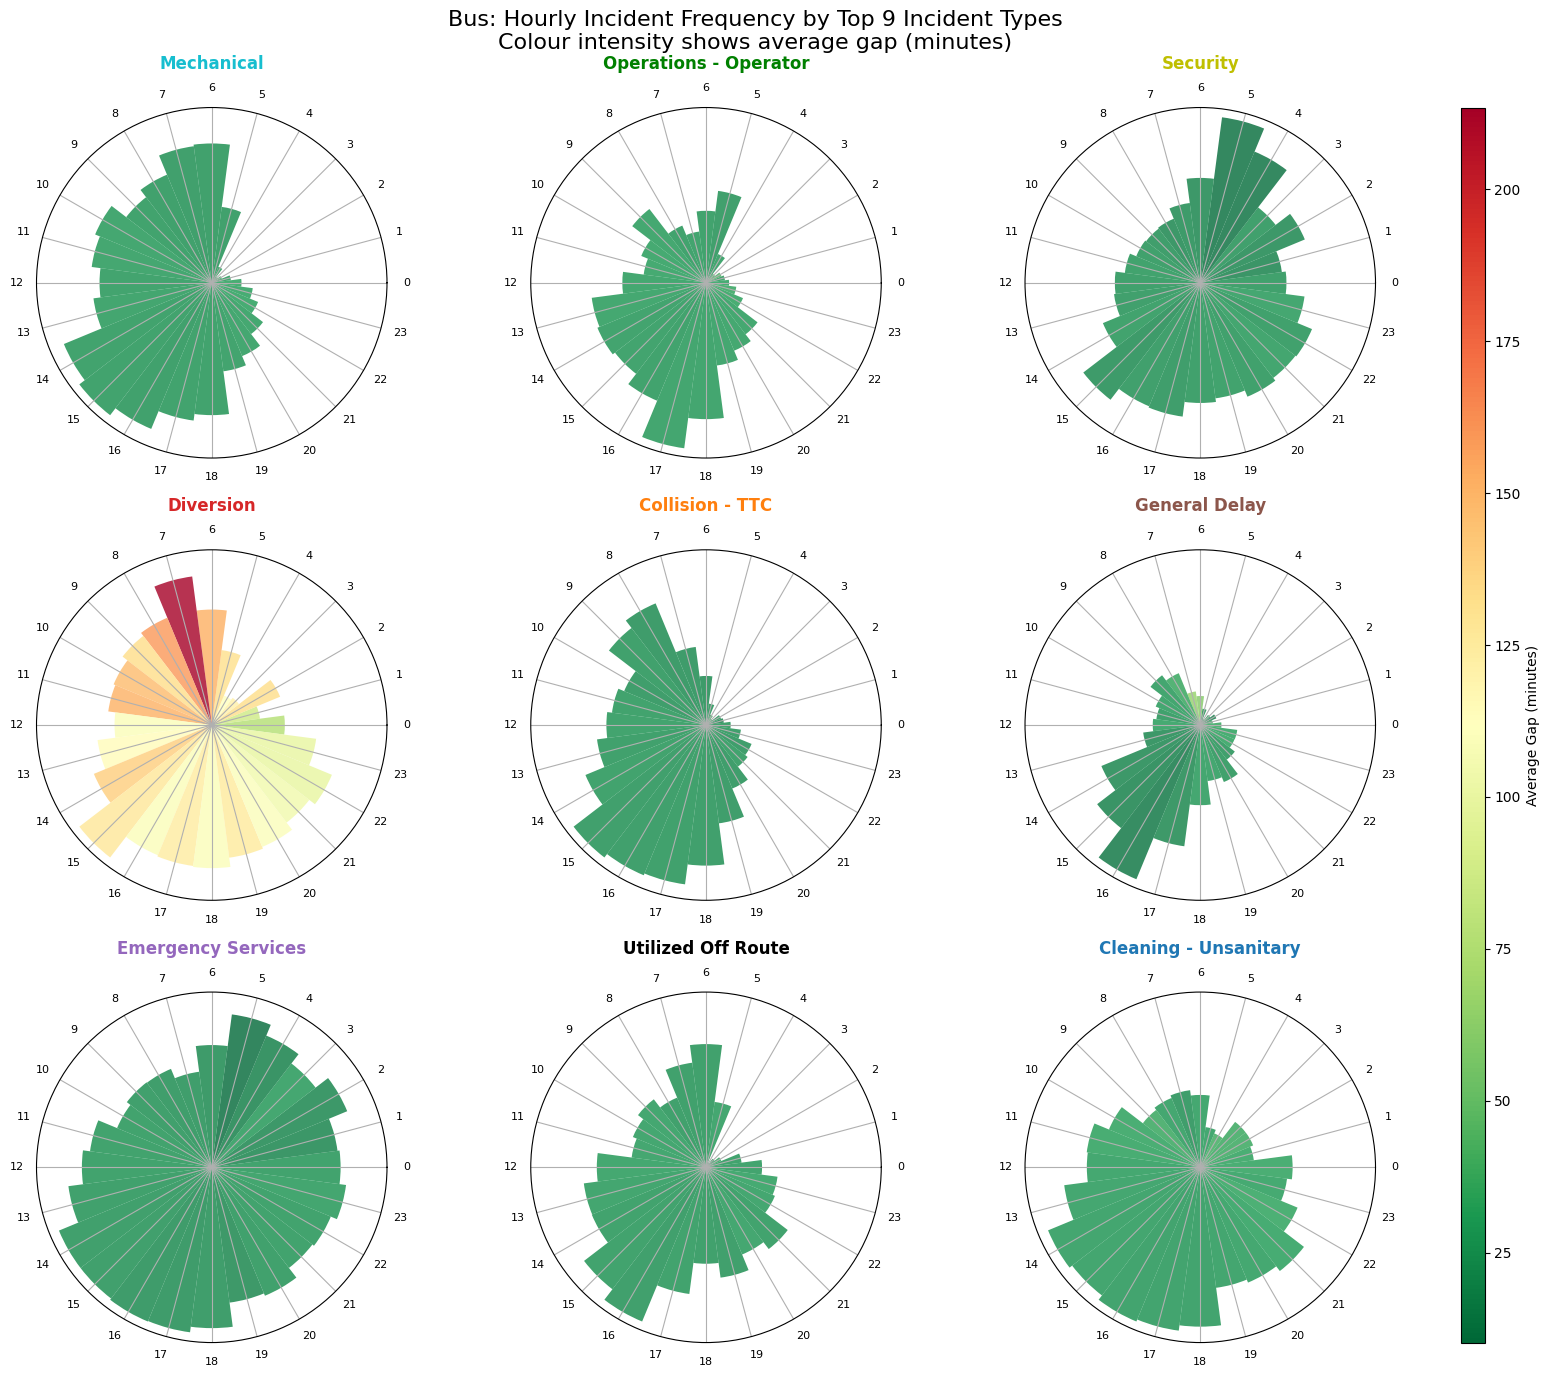

In [27]:
def radial_grid_by_incident(df, mode='Streetcar'):
    top_incidents = df['Incident'].value_counts().head(9).index

    # calculate the global min and max gap values across all incidents
    all_gap_values = []
    for incident in top_incidents:
        subset = df[df['Incident'] == incident].copy()
        subset['Hour'] = pd.to_datetime(subset['Time'], format='%H:%M', errors='coerce').dt.hour
        hourly_stats = subset.groupby('Hour').agg({
            'Min Delay': 'count',
            'Min Gap': 'mean'
        }).reindex(range(24), fill_value=0)
        all_gap_values.extend(hourly_stats['Min Gap'].values)
    
    # create a global normalization for all plots
    global_norm = plt.Normalize(min(all_gap_values), max(all_gap_values))

    # create figure with GridSpec to properly handle the colourbar
    fig = plt.figure(figsize=(16, 14))
    gs = plt.GridSpec(3, 4, figure=fig, width_ratios=[1, 1, 1, 0.05])
    fig.suptitle(f'{mode}: Hourly Incident Frequency by Top 9 Incident Types\nColour intensity shows average gap (minutes)', fontsize=16)

    for i, incident in enumerate(top_incidents):
        ax = fig.add_subplot(gs[i//3, i%3], polar=True)
        subset = df[df['Incident'] == incident].copy()
        subset['Hour'] = pd.to_datetime(subset['Time'], format='%H:%M', errors='coerce').dt.hour
        
        # calculate both frequency and average gap
        hourly_stats = subset.groupby('Hour').agg({
            'Min Delay': 'count',  # count for frequency
            'Min Gap': 'mean'      # mean for color
        }).reindex(range(24), fill_value=0)

        theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)
        radii = hourly_stats['Min Delay'].values  # frequency for bar length
        gap_values = hourly_stats['Min Gap'].values

        # Use global normalization for consistent colors
        colors = plt.cm.RdYlGn_r(global_norm(gap_values))
        width = (2*np.pi) / 24

        bars = ax.bar(theta, radii, width=width, color=colors, alpha=0.8)
        # set title with incident color from incident_colors dictionary
        title_color = incident_colors.get(incident, 'black')  # fallback to black if incident not in dictionary
        ax.set_title(incident, fontsize=12, fontweight='bold', color=title_color, pad=10)
        ax.set_xticks(theta)
        ax.set_xticklabels(range(24), fontsize=8)
        ax.set_yticks([])

    # add colourbar in the last column
    cbar_ax = fig.add_subplot(gs[:, -1])
    sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=global_norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Average Gap (minutes)')

    plt.tight_layout()
    filename = f'{mode.lower()}_hourly_frequency_by_incident_type.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



radial_grid_by_incident(streetcar_all_clean, mode='Streetcar')
radial_grid_by_incident(bus_all_clean, mode='Bus')


Some further visualization experimentations that didn't make  it into the report:

In [43]:
def add_mode_label(df, mode):
    df = df.copy()
    df['Mode'] = mode
    return df


def plot_monthly_trends_grid(dfs_dict):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    axes = axes.flatten()
    for i, (mode, df) in enumerate(dfs_dict.items()):
        df['Month'] = pd.to_datetime(df['Date'], errors='coerce').dt.to_period('M')
        counts = df.groupby('Month').size()
        counts.plot(ax=axes[i], marker='o', color='steelblue')
        axes[i].set_title(f'{mode}: Monthly Incident Count')
        axes[i].set_xlabel('Month')
        axes[i].set_ylabel('Incidents')
        axes[i].grid(True)

    plt.suptitle('Monthly Incident Trends by Mode', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_heatmap_grid(dfs_dict):
    fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True)
    axes = axes.flatten()
    for i, (mode, df) in enumerate(dfs_dict.items()):
        df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
        heatmap_data = df.pivot_table(index='Day', columns='Hour', values='Min Delay', aggfunc='mean').reindex(
            ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        sns.heatmap(heatmap_data, ax=axes[i], cmap='YlOrRd', annot=True, fmt=".1f", cbar=False)
        axes[i].set_title(f'{mode}: Mean Delay by Hour and Day')
        axes[i].set_ylabel('Day')
        axes[i].set_xlabel('Hour')

    plt.suptitle('Delay Intensity Heatmaps (Hour × Day)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


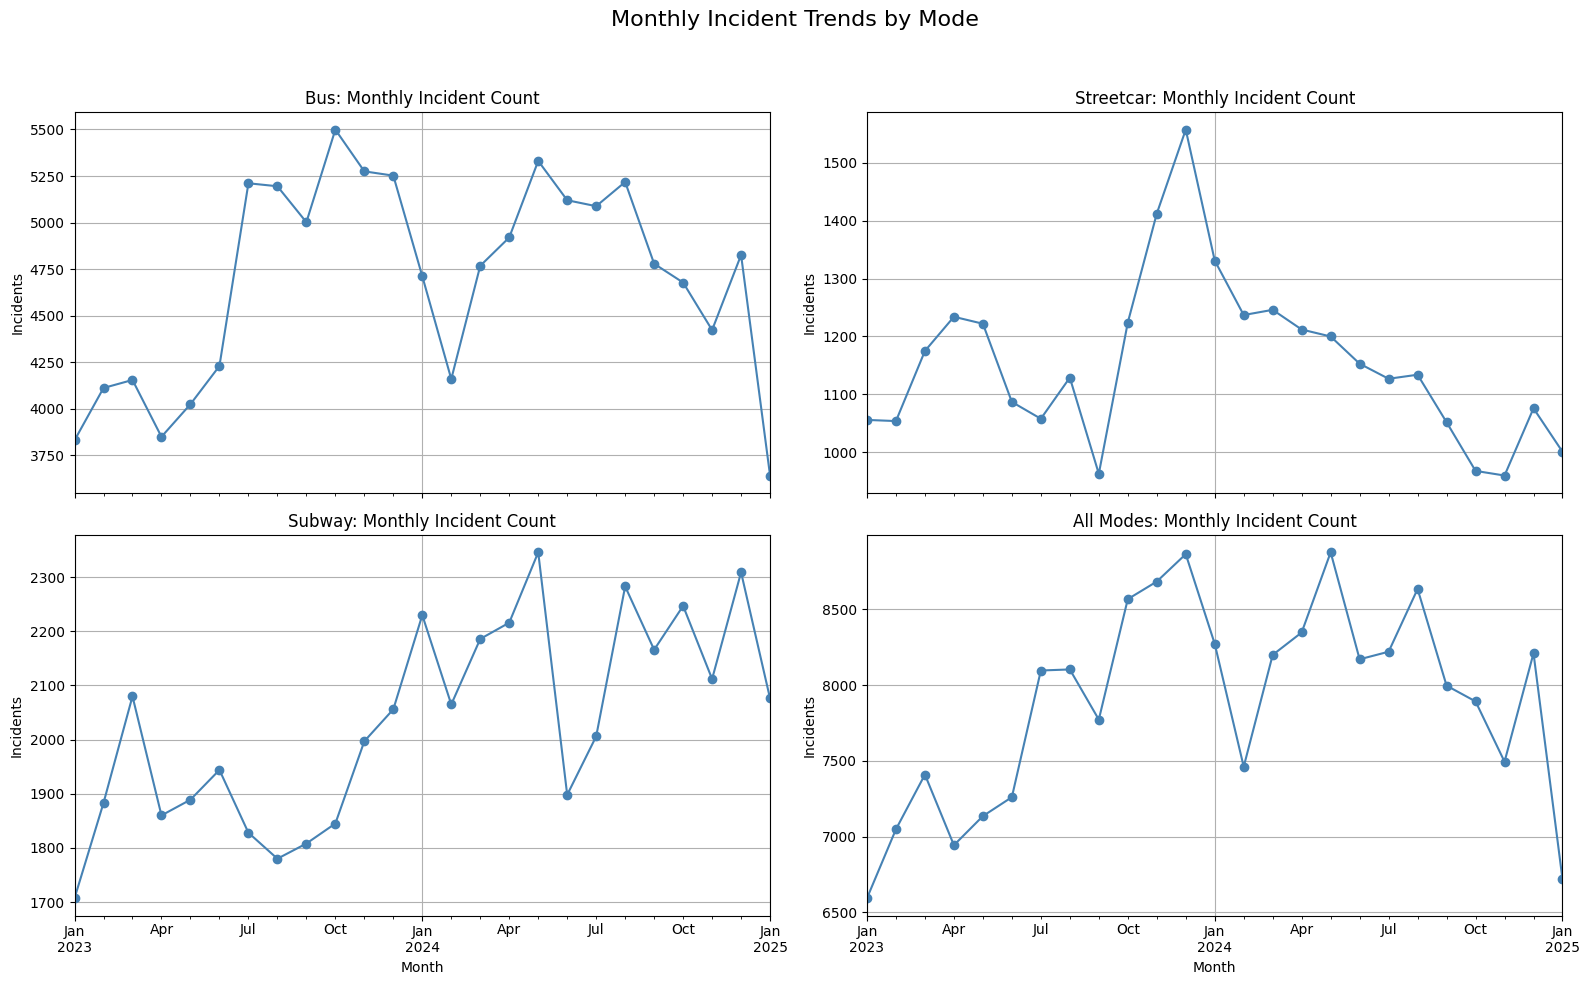

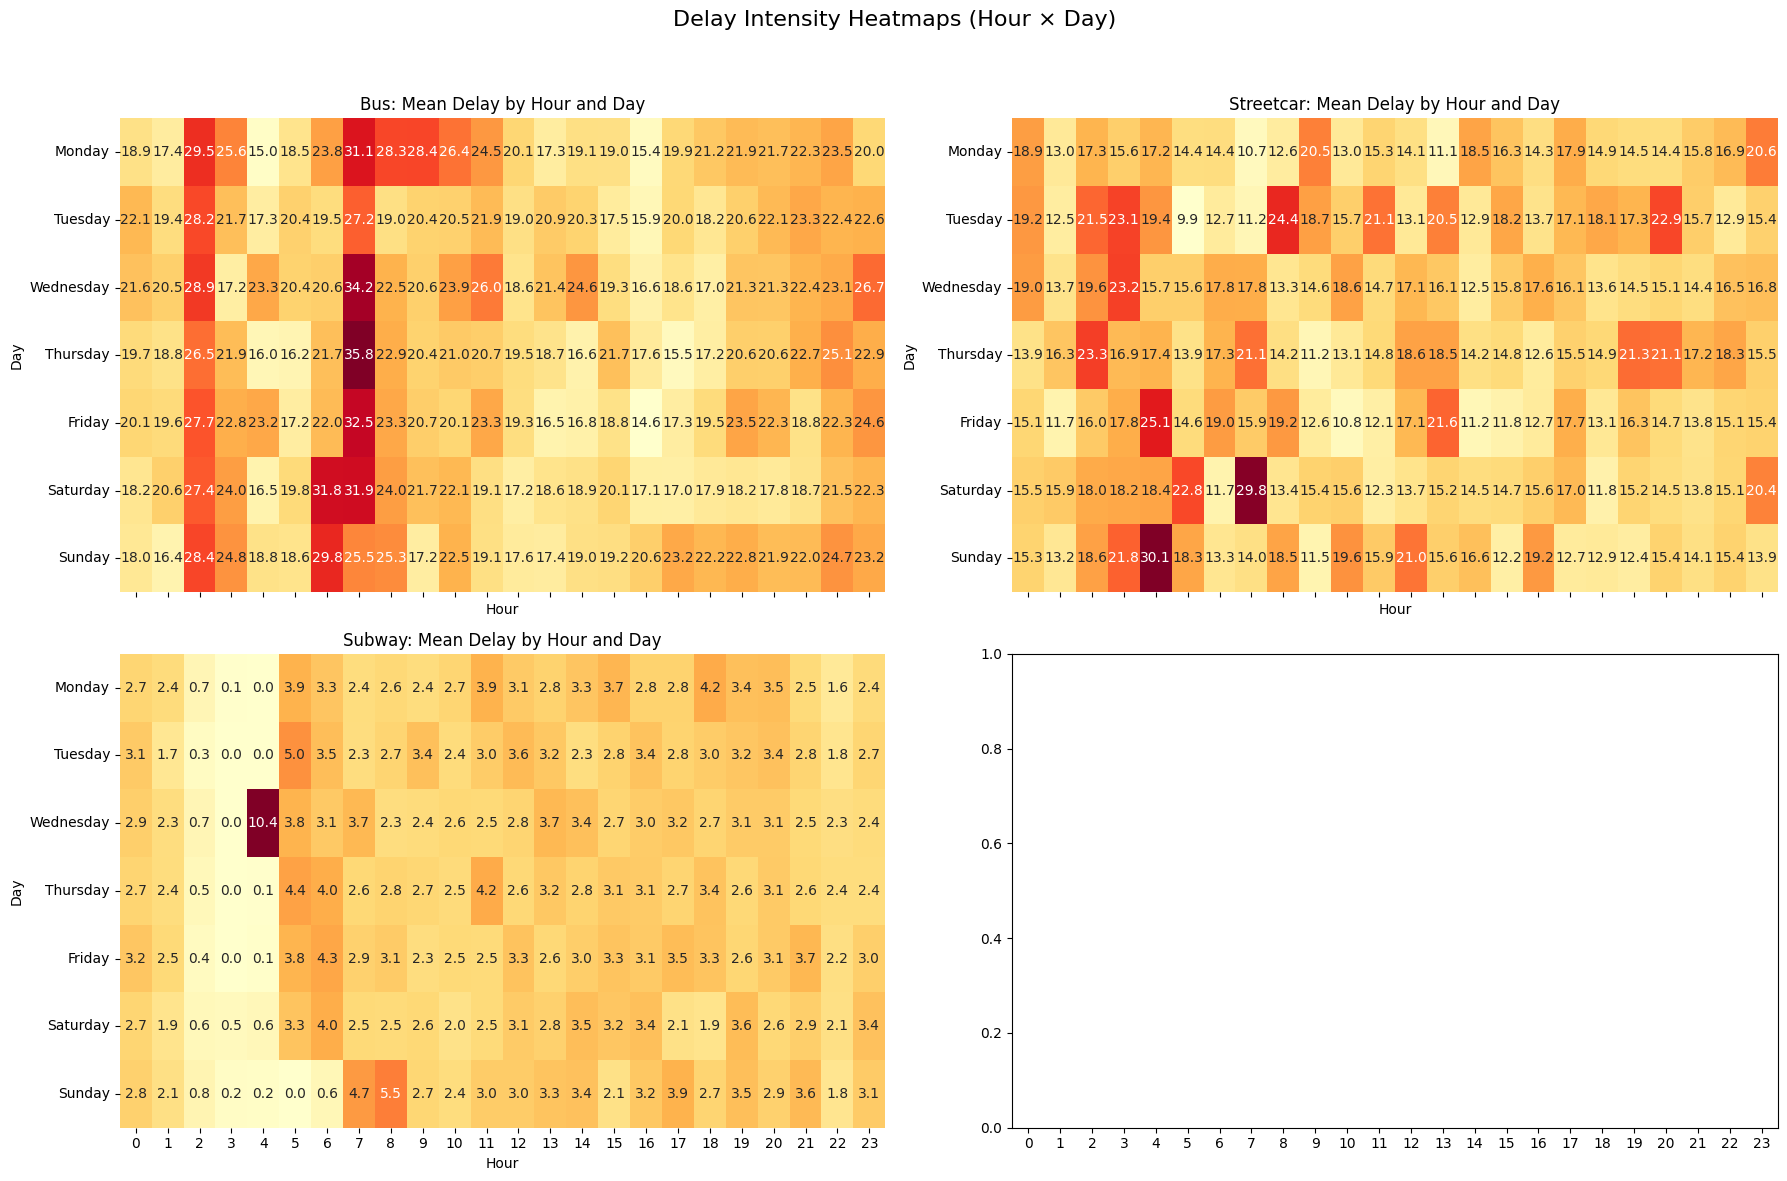

In [42]:
# data dictionary
dfs_by_mode = {
    'Bus': bus_all_clean.copy(),
    'Streetcar': streetcar_all_clean.copy(),
    'Subway': subway_all_clean.copy(),
    'All Modes': pd.concat([
        add_mode_label(bus_all_clean, 'Bus'),
        add_mode_label(streetcar_all_clean, 'Streetcar'),
        add_mode_label(subway_all_clean, 'Subway')
    ])
}

# monthly trends
plot_monthly_trends_grid(dfs_by_mode)


plot_heatmap_grid({k: v for k, v in dfs_by_mode.items() if k != 'All Modes'})


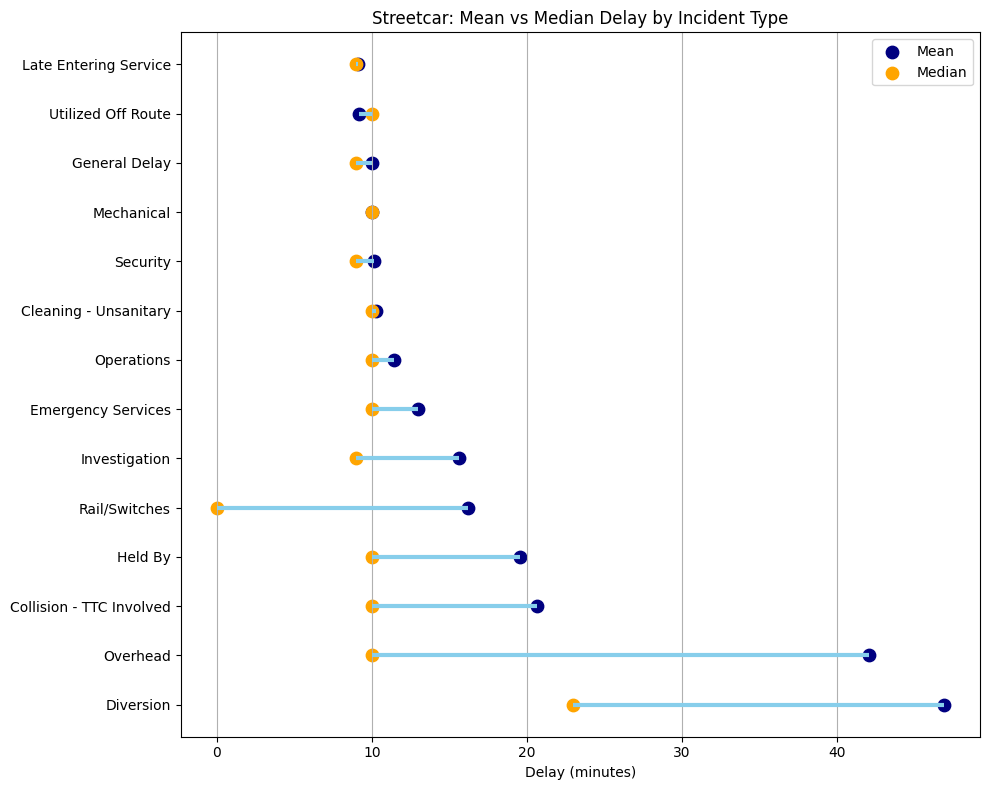

In [44]:
streetcar_stats = streetcar_all_clean.groupby('Incident')['Min Delay'].agg(['mean', 'median']).reset_index()
top_incidents = streetcar_stats.sort_values('mean', ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.hlines(y=top_incidents['Incident'], xmin=top_incidents['median'], xmax=top_incidents['mean'], color='skyblue', lw=3)
plt.scatter(top_incidents['mean'], top_incidents['Incident'], color='navy', label='Mean', s=80)
plt.scatter(top_incidents['median'], top_incidents['Incident'], color='orange', label='Median', s=80)
plt.xlabel('Delay (minutes)')
plt.title('Streetcar: Mean vs Median Delay by Incident Type')
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()
